In [6]:
# -*- coding: utf-8 -*-
"""
Created on Wed May 6 2021

@authors: R. van Hoof & A. Lozano
"""

# %matplotlib inline

'\nCreated on Wed May 6 2021\n\n@authors: R. van Hoof & A. Lozano\n'

In [7]:
import time
import os.path
import pickle # needed to store the results
from copy import deepcopy
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
from scipy.stats import entropy
from sklearn.metrics import mutual_info_score as MI
from skopt.utils import use_named_args
from skopt.space import Integer, Categorical, Real
from skopt.utils import cook_initial_point_generator
from skopt import gp_minimize

########################
### Custom functions ###
########################
from ninimplant import pol2cart, get_xyz # matrix rotation/translation ect
from lossfunc import DC, KL, get_yield, hellinger_distance
from electphos import create_grid, reposition_grid, implant_grid, get_phosphenes, prf_to_phos, gen_dummy_phos, get_cortical_magnification, cortical_spread
import visualsectors as gvs

# ignore "True-divide" warning
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

In [8]:
##########
## INIT ##
##########

# datafolder = '/path/to/data/'
# outputfolder = '/path/to/data/'
# datafolder = 'F:/Rick/Surfdrive_BACKUP/Data/NESTOR/HCP/subjects/'
# datafolder = r'C:/Users/Lozano/Desktop/NIN/bayesian_optimization_paper/data/subjects/'
# outputfolder =  r'C:/Users/Lozano/Desktop/NIN/bayesian_optimization_paper/data/output/'
datafolder = "C:/Users/user/YongtaeC/vimplant0812/data/input/102311/"
outputfolder = "C:/Users/user/YongtaeC/vimplant0812/data/output/102311/"
os.makedirs(outputfolder, exist_ok=True)

# determine range of parameters used in optimization
dim1 = Integer(name='alpha', low=-90, high=90) # visual degrees 
dim2 = Integer(name='beta', low=-15, high=110) # visual degrees - -15 is probably lowest possible angle, otherwise other hem is in the way if hem = RH -> low = -110, high = 15
dim3 = Integer(name='offset_from_base', low=0, high=40) # in mm
dim4 = Integer(name='shank_length', low=10, high=40) # mm
dimensions = [dim1, dim2, dim3, dim4]

num_calls = 150
x0 = (0,0,20,25) # initial values for the four dimensions
num_initial_points = 10
dc_percentile = 50
n_contactpoints_shank = 10
spacing_along_xy = 1
WINDOWSIZE = 1000

# lists of loss term combinations to loop through
    # Dice Coefficient (1, 0, 0)
    # Yield (0, 1, 0)
    # Hellinger Distance (0, 0, 1)
loss_comb = ([(1, 0.1, 1)]) # weights for loss terms
loss_names = (['dice-yield-HD']) # substring in output filename

# lists of target maps to loop through
targ_comb = ([gvs.upper_sector(windowsize=WINDOWSIZE, fwhm=800, radiusLow=0, radiusHigh=500, plotting=False), 
              gvs.lower_sector(windowsize=WINDOWSIZE, fwhm=800, radiusLow=0, radiusHigh=500, plotting=False),
              gvs.inner_ring(windowsize=WINDOWSIZE, fwhm=400, radiusLow=0, radiusHigh=250, plotting=False),
              gvs.complete_gauss(windowsize=1000, fwhm=1200, radiusLow=0, radiusHigh=500, center=None, plotting=False)])
targ_names = (['targ-upper', 'targ-lower', 'targ-inner', 'targ-full'])

# constants pRF model
cort_mag_model = 'wedge-dipole' # which cortex model to use for the cortical magnification
view_angle = 90 #in degrees of visual angle
amp = 100 #stimulation amplitude in micro-amp (higher stimulation -> more tissue activated)

# INIT Bayes
amax = 1
bmax = 1
cmax = 1000
N=5
delta=0.2
thresh=0.05

# subjects to include
subj_list = [118225, 144226, 162935, 176542, 187345, 200614, 251833, 389357, 547046, 671855, 789373, 901139,  
100610, 125525, 145834, 164131, 177140, 191033, 201515, 257845, 393247, 550439, 680957, 814649, 901442, 
102311, 126426, 146129, 164636, 177645, 191336, 203418, 263436, 395756, 552241, 690152, 818859, 905147, 
102816, 128935, 146432, 165436, 177746, 191841, 204521, 283543, 397760, 562345, 706040, 825048, 910241, 
104416, 130114, 146735, 167036, 178142, 192439, 205220, 318637, 401422, 572045, 724446, 826353, 926862, 
105923, 130518, 146937, 167440, 178243, 192641, 209228, 320826, 406836, 573249, 725751, 833249, 927359, 
108323, 131217, 148133, 169040, 178647, 193845, 212419, 330324, 412528, 581450, 732243, 859671, 942658, 
109123, 131722, 150423, 169343, 180533, 195041, 214019, 346137, 429040, 585256, 751550, 861456, 943862, 
111312, 132118, 155938, 169444, 181232, 196144, 214524, 352738, 436845, 601127, 757764, 871762, 951457, 
111514, 134627, 156334, 169747, 181636, 197348, 221319, 360030, 463040, 617748, 765864, 872764, 958976, 
114823, 134829, 157336, 171633, 182436, 198653, 233326, 365343, 467351, 627549, 770352, 878776, 966975, 
115017, 135124, 158035, 172130, 182739, 199655, 239136, 380036, 525541, 638049, 771354, 878877, 971160, 
115825, 137128, 158136, 173334, 185442, 200210, 246133, 381038, 536647, 644246, 782561, 898176, 973770, 
116726, 140117, 159239, 175237, 186949, 200311, 249947, 385046, 541943, 654552, 783462, 899885, 995174, 'fsaverage']

subj_list = [100206]
subj_list = [102311]

In [9]:
################################################
## Functions related to Bayesian optimization ##
################################################

def custom_stopper(res, N=5, delta=0.2, thresh=0.05):
    '''
    Returns True (stops the optimization) when 
    the difference between best and worst of the best N are below delta AND the best is below thresh
    
    N = last number of cost values to track
    delta = ratio best and worst
    
    '''
    
    if len(res.func_vals) >= N:
        func_vals = np.sort(res.func_vals)
        worst = func_vals[N - 1]
        best = func_vals[0]
        
        return (abs((best - worst)/worst) < delta) & (best < thresh)
    else:
        return None

@use_named_args(dimensions=dimensions)
def f(alpha, beta, offset_from_base, shank_length):
    """
    This function encapsulates the electrode placement procedure and returns the cost value by 
    comparing the resulting phosphene map with the target map.    
    * First it creats a grid based on the four parameters. 
    * Phosphenes are generated based on the grid's contact points, 
      and their sizes are determined using cortical magnification and spread values. 
    * These phosphenes are converted into a 2D image representation. 
      The function then computes the dice coefficient and yield, and calculates the Hellinger 
      distance between the generated image and a target density. 
    * The resulting cost is a combination of these factors, 
      with penalties applied if the grid is invalid. 
    * The function also handles cases of invalid values and prints diagnostic information. 
    * Ultimately, the function returns the calculated cost used by the bayesopt algorithm.
    """
    
    penalty = 0.25
    new_angle = (float(alpha), float(beta), 0)    
    
    # create grid
    orig_grid = create_grid(start_location, shank_length, n_contactpoints_shank, spacing_along_xy, offset_from_origin=0)
    
    # implanting grid
    _, contacts_xyz_moved, _, _, _, _, _, _, grid_valid = implant_grid(gm_mask, orig_grid, start_location, new_angle, offset_from_base)

    # get angle, ecc and rfsize for contactpoints (phosphenes[0-2][:] 0 angle x 1 ecc x 2 rfsize)    
    phosphenes = get_phosphenes(contacts_xyz_moved, good_coords, polar_map, ecc_map, sigma_map)
    phosphenes_V1 = get_phosphenes(contacts_xyz_moved, good_coords_V1, polar_map, ecc_map, sigma_map)
    phosphenes_V2 = get_phosphenes(contacts_xyz_moved, good_coords_V2, polar_map, ecc_map, sigma_map)   
    phosphenes_V3 = get_phosphenes(contacts_xyz_moved, good_coords_V3, polar_map, ecc_map, sigma_map)
    
    #the inverse cortical magnification in degrees (visual angle)/mm tissue
    M = 1 / get_cortical_magnification(phosphenes_V1[:,1], cort_mag_model) 
    spread = cortical_spread(amp) #radius of current spread in the tissue, in mm
    sizes = spread*M #radius of current spread * cortical magnification = rf radius in degrees
    sigmas = sizes / 2  # radius to sigma of gaussian
    
    # phosphene size based on CMF + stim amp
    phosphenes_V1[:,2] = sigmas

    # generate map using Gaussians
    # transforming obtained phosphenes to a 2d image    
    phospheneMap = np.zeros((WINDOWSIZE,WINDOWSIZE), 'float32') 
    phospheneMap = prf_to_phos(phospheneMap, phosphenes_V1, view_angle=view_angle, phSizeScale=1)    
    phospheneMap /= phospheneMap.max()
    phospheneMap /= phospheneMap.sum()

    # bin_thesh determines size target
    bin_thresh=np.percentile(target_density, dc_percentile)# np.min(target_density) 

    # compute dice coefficient -> should be 1 -> invert cost 
    dice, im1, im2 = DC(target_density, phospheneMap, bin_thresh)
    par1 = 1.0 - (a * dice)

    # compute yield -> should be 1 -> invert cost
    grid_yield = get_yield(contacts_xyz_moved, good_coords)
    par2 = 1.0 - (b * grid_yield)

    # compute hellinger distance -> should be small -> keep cost
    hell_d = hellinger_distance(phospheneMap.flatten(), target_density.flatten())    
    
    ## validations steps
    if np.isnan(phospheneMap).any() or np.sum(phospheneMap) == 0:
        par1 = 1
        print('map is nan or 0')
    
    if np.isnan(hell_d) or np.isinf(hell_d):
        par3 = 1
        print('Hellington is nan or inf')
    else:
        par3 = c * hell_d
    
    # combine cost functions
    cost = par1 + par2 + par3

    # when some contact points are outside of the hemisphere (convex), add penalty
    if not grid_valid:
        cost = par1 + penalty + par2 + penalty + par3 + penalty
    
    # check if cost contains invalid value
    if np.isnan(cost) or np.isinf(cost):
        cost = 3
    
    print('    ', "{:.2f}".format(cost), "{:.2f}".format(dice), "{:.2f}".format(grid_yield), "{:.2f}".format(par3), grid_valid)
    return cost

def f_manual(alpha, beta, offset_from_base, shank_length, good_coords, good_coords_V1, good_coords_V2, good_coords_V3, target_density):
    '''
    Copy from f, to obtain phosphene map and contact points for the optimized parameters. Used to visualize results.

    also returns coords used ect.
    '''
    
    penalty = 0.25
    new_angle = (float(alpha), float(beta), 0)
    
    # create grid
    orig_grid = create_grid(start_location, shank_length, n_contactpoints_shank, spacing_along_xy, offset_from_origin=0)

    # implanting grid
    ref_contacts_xyz, contacts_xyz_moved, refline, refline_moved, projection, ref_orig, ray_visualize, new_location, grid_valid = implant_grid(gm_mask, orig_grid, start_location, new_angle, offset_from_base)

    # get angle, ecc and rfsize for contactpoints in each ROI (phosphenes[0-2][:] 0 angle x 1 ecc x 2 rfsize)
    phosphenes =    get_phosphenes(contacts_xyz_moved, good_coords, polar_map, ecc_map, sigma_map)
    phosphenes_V1 = get_phosphenes(contacts_xyz_moved, good_coords_V1, polar_map, ecc_map, sigma_map)
    phosphenes_V2 = get_phosphenes(contacts_xyz_moved, good_coords_V2, polar_map, ecc_map, sigma_map)
    phosphenes_V3 = get_phosphenes(contacts_xyz_moved, good_coords_V3, polar_map, ecc_map, sigma_map)
    
    #the inverse cortical magnification in degrees (visual angle)/mm tissue
    M = 1 / get_cortical_magnification(phosphenes_V1[:,1], cort_mag_model)
    spread = cortical_spread(amp) #radius of current spread in the tissue, in mm
    sizes = spread*M #radius of current spread * cortical magnification = rf radius in degrees
    sigmas = sizes / 2  # radius to sigma of gaussian
    
    # phosphene size based on CMF + stim amp
    phosphenes_V1[:,2] = sigmas

    # generate map using Gaussians
    # transforming obtained phosphenes to a 2d image
    phospheneMap = np.zeros((WINDOWSIZE,WINDOWSIZE), 'float32')
    phospheneMap = prf_to_phos(phospheneMap, phosphenes_V1, view_angle=view_angle, phSizeScale=1)
    phospheneMap /= phospheneMap.max()
    phospheneMap /= phospheneMap.sum()
    print(view_angle)
    
    # can we relate bin_thesh to an eccentricity value? -> taken care of by masking the targets -> CHANGE TO 0.99999
    bin_thresh=np.percentile(target_density, dc_percentile)# np.min(target_density) # bin_thesh determines size target

    # compute dice coefficient -> should be large -> invert cost 
    dice, im1, im2 = DC(target_density, phospheneMap, bin_thresh)
    par1 = 1.0 - (a * dice)

    # compute yield -> should be 1 -> invert cost
    grid_yield = get_yield(contacts_xyz_moved, good_coords)
    par2 = 1.0 - (b * grid_yield)  
    
    # very important to normalize target density to same range as phospheneMap!
    target_density /= target_density.max()
    target_density /= target_density.sum()        
    
    # compute Hellinger distance -> should be small -> keep cost
    hell_d = hellinger_distance(phospheneMap.flatten(), target_density.flatten())
    
    ## validations steps
    if np.isnan(phospheneMap).any() or np.sum(phospheneMap) == 0:
        par1 = 1
        print('map is nan or 0')
    
    if np.isnan(hell_d) or np.isinf(hell_d):
        par3 = 1
        print('Hellington is nan or inf')
    else:
        par3 = c * hell_d
    
    # combine cost functions
    cost = par1 + par2 + par3

    # when some contact points are outside of the hemisphere (convex), add penalty
    if not grid_valid:
        cost = par1 + penalty + par2 + penalty + par3 + penalty
    
    # check if cost contains invalid value
    if np.isnan(cost) or np.isinf(cost):
        cost = 3
    
    return grid_valid, dice, hell_d, grid_yield, phosphenes, phosphenes_V1, phosphenes_V2, phosphenes_V3, contacts_xyz_moved, phospheneMap

number of subjects: 1
target:  targ-upper
loss:  dice-yield-HD
a,b,c:  1 0.1 1
     2.60 0.24 0.50 0.89 True
     2.92 0.02 0.33 0.98 True
     2.78 0.10 0.40 0.92 True
     2.81 0.08 0.42 0.94 True
     3.62 0.04 0.16 0.93 False
     2.76 0.12 0.55 0.93 True
     2.89 0.05 0.15 0.95 True
     2.88 0.07 0.16 0.96 True
map is nan or 0
Hellington is nan or inf
     2.96 0.00 0.42 1.00 True
     3.63 0.04 0.34 0.96 False
     3.57 0.08 0.24 0.92 False
     2.97 0.00 0.28 1.00 True
map is nan or 0
Hellington is nan or inf
     3.75 0.00 0.00 1.00 False
     3.69 0.00 0.48 1.00 False
     2.77 0.10 0.47 0.91 True
     2.89 0.04 0.39 0.97 True
     3.62 0.05 0.34 0.95 False
     2.65 0.19 0.48 0.88 True
     3.45 0.16 0.35 0.90 False
     2.36 0.40 0.44 0.80 True
     2.58 0.24 0.39 0.85 True
     2.82 0.09 0.41 0.95 True
     2.84 0.07 0.39 0.95 True
     2.82 0.08 0.26 0.92 True
map is nan or 0
Hellington is nan or inf
     2.99 0.00 0.08 1.00 True
map is nan or 0
Hellington is nan or inf


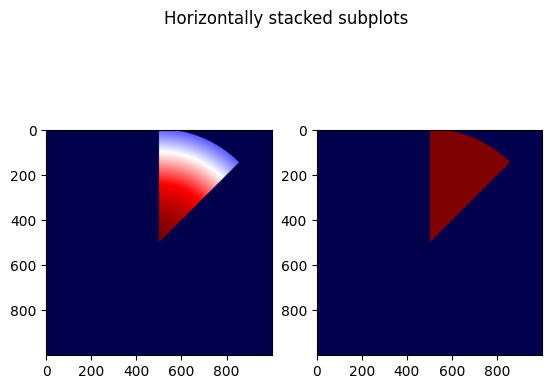

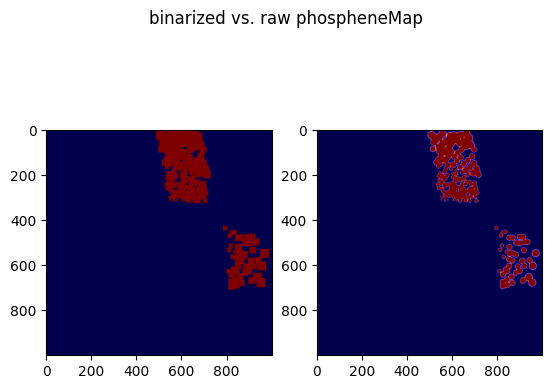

    max phospheneMap:  0.00016758975
     2.67 0.19 0.45 0.91 True
map is nan or 0
Hellington is nan or inf
     2.99 0.00 0.10 1.00 True
     2.85 0.06 0.44 0.95 True
     2.90 0.03 0.41 0.98 True
     3.71 0.00 0.36 1.00 False
     2.63 0.25 0.14 0.90 True
map is nan or 0
Hellington is nan or inf
     3.71 0.00 0.40 1.00 False
     3.68 0.02 0.23 0.97 False
     2.94 0.01 0.27 0.98 True
     2.89 0.04 0.40 0.97 True
     3.61 0.06 0.23 0.95 False
     2.81 0.10 0.46 0.96 True
     2.95 0.02 0.18 0.99 True
     2.91 0.02 0.37 0.97 True
     2.86 0.05 0.54 0.96 True
     3.72 0.00 0.26 1.00 False
     2.66 0.23 0.10 0.90 True
     2.40 0.42 0.28 0.84 True
map is nan or 0
Hellington is nan or inf
     3.74 0.00 0.08 1.00 False
map is nan or 0
Hellington is nan or inf
     2.99 0.00 0.08 1.00 True
     2.26 0.50 0.37 0.80 True
     2.44 0.36 0.33 0.84 True
     2.45 0.38 0.36 0.87 True
     2.37 0.40 0.45 0.82 True
     2.55 0.30 0.35 0.89 True
map is nan or 0
Hellington is nan or inf
  

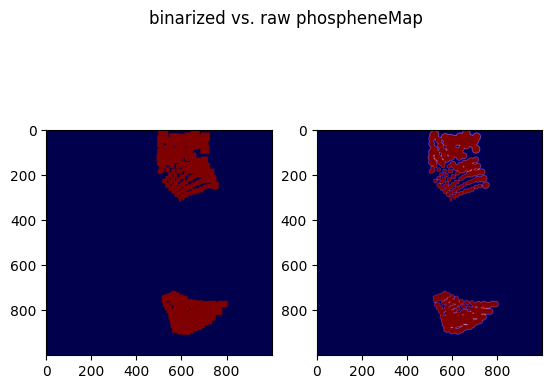

    max phospheneMap:  8.3656145e-05
target:  targ-lower
loss:  dice-yield-HD
a,b,c:  1 0.1 1
     2.88 0.05 0.50 0.98 True
     3.72 0.00 0.33 1.00 False
     2.97 0.00 0.32 1.00 True
     2.96 0.00 0.38 1.00 True
     2.96 0.00 0.42 1.00 True
     3.70 0.01 0.37 0.99 False
     3.68 0.02 0.27 0.98 False
     2.97 0.00 0.23 1.00 True
     3.62 0.06 0.35 0.97 False
     2.96 0.00 0.41 1.00 True
map is nan or 0
Hellington is nan or inf
     2.97 0.00 0.34 1.00 True
     2.96 0.00 0.38 1.00 True
map is nan or 0
Hellington is nan or inf
     3.70 0.00 0.55 1.00 False
     2.84 0.08 0.45 0.97 True
     2.99 0.00 0.08 1.00 True
map is nan or 0
Hellington is nan or inf
     3.69 0.00 0.59 1.00 False
     3.70 0.01 0.32 0.99 False
     2.97 0.00 0.29 1.00 True
     2.86 0.07 0.45 0.97 True
     3.68 0.02 0.38 0.99 False
     2.82 0.10 0.46 0.96 True
     3.68 0.02 0.42 0.99 False
     2.81 0.10 0.46 0.95 True
     2.96 0.00 0.44 1.00 True
     2.77 0.13 0.46 0.94 True
     2.84 0.08 0.49 0.97

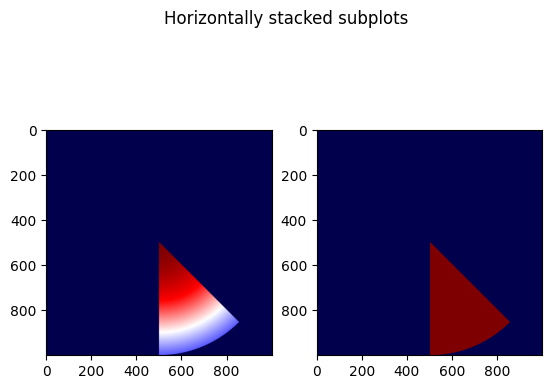

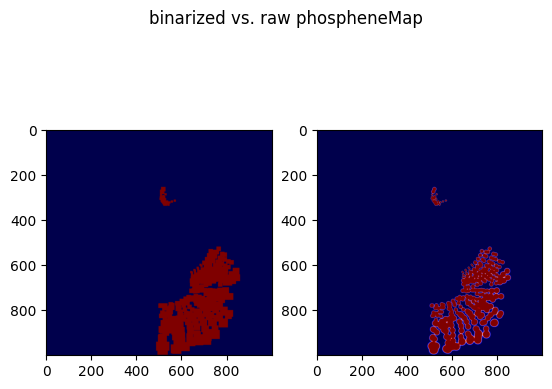

    max phospheneMap:  0.00012574064
     2.76 0.13 0.45 0.94 True
     2.84 0.07 0.34 0.95 True
     2.97 0.00 0.33 1.00 True
     2.79 0.14 0.11 0.95 True
     3.63 0.05 0.29 0.96 False
     2.60 0.23 0.36 0.87 True
map is nan or 0
Hellington is nan or inf
     2.98 0.00 0.23 1.00 True
     3.66 0.03 0.28 0.97 False
map is nan or 0
Hellington is nan or inf
     2.94 0.00 0.56 1.00 True
     3.65 0.02 0.28 0.95 False
     3.56 0.08 0.37 0.93 False
     2.49 0.33 0.40 0.86 True
     2.83 0.07 0.47 0.94 True
     3.31 0.28 0.44 0.88 False
     2.82 0.08 0.29 0.94 True
     2.66 0.21 0.46 0.91 True
     3.65 0.04 0.27 0.97 False
     2.39 0.41 0.32 0.84 True
     2.47 0.37 0.28 0.87 True
     2.44 0.37 0.39 0.85 True
     2.88 0.05 0.23 0.95 True
     2.43 0.39 0.28 0.85 True
     2.28 0.49 0.33 0.80 True
     2.31 0.46 0.33 0.80 True
map is nan or 0
Hellington is nan or inf
     3.69 0.00 0.56 1.00 False
     2.28 0.48 0.35 0.79 True
     2.31 0.46 0.34 0.80 True
     2.31 0.46 0.39 0.8

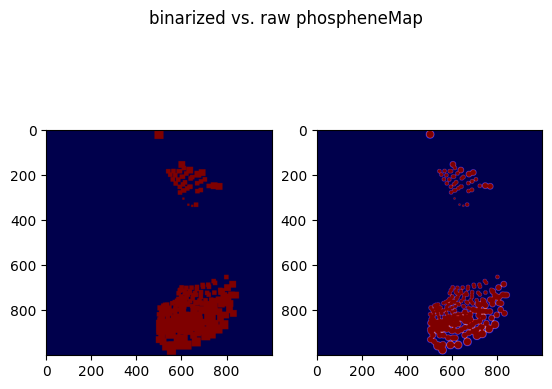

    max phospheneMap:  0.000108758155
target:  targ-inner
loss:  dice-yield-HD
a,b,c:  1 0.1 1
     2.74 0.14 0.50 0.94 True
     2.97 0.00 0.28 1.00 True
     2.57 0.24 0.38 0.84 True
     3.26 0.27 0.38 0.82 False
     2.51 0.25 0.44 0.80 True
     3.43 0.16 0.29 0.87 False
     2.82 0.07 0.23 0.92 True
     3.43 0.16 0.34 0.87 False
map is nan or 0
Hellington is nan or inf
     2.97 0.00 0.27 1.00 True
     2.47 0.30 0.41 0.81 True
     2.62 0.20 0.40 0.85 True
     2.51 0.26 0.44 0.81 True
     2.67 0.16 0.37 0.87 True
     2.70 0.14 0.35 0.87 True
     2.56 0.24 0.32 0.83 True
     2.74 0.15 0.15 0.90 True
map is nan or 0
Hellington is nan or inf
     3.70 0.00 0.54 1.00 False
     2.52 0.28 0.39 0.84 True
     2.45 0.30 0.47 0.80 True
     2.66 0.17 0.38 0.87 True
     3.25 0.28 0.38 0.82 False
     3.46 0.13 0.39 0.88 False
     2.58 0.21 0.33 0.83 True
     2.91 0.02 0.41 0.97 True
     3.46 0.15 0.16 0.87 False
     2.99 0.00 0.07 1.00 True
     2.46 0.31 0.50 0.81 True
     3

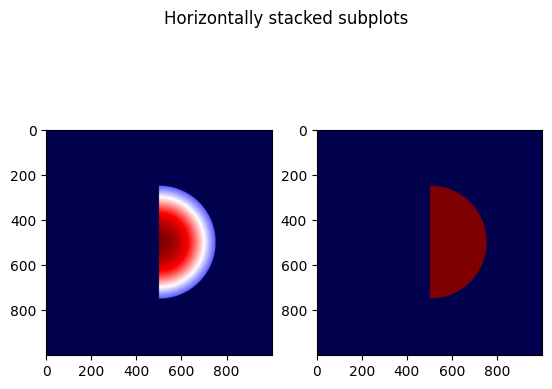

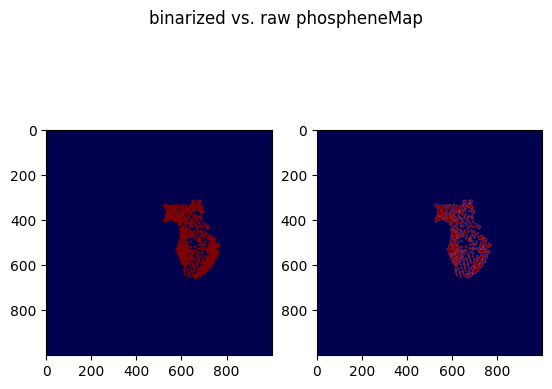

    max phospheneMap:  0.00033468535
     2.75 0.14 0.45 0.93 True
     2.97 0.00 0.26 1.00 True
map is nan or 0
Hellington is nan or inf
     3.74 0.00 0.12 1.00 False
     3.45 0.15 0.22 0.87 False
     2.56 0.24 0.31 0.83 True
     2.42 0.32 0.53 0.79 True
     2.62 0.20 0.37 0.86 True
map is nan or 0
Hellington is nan or inf
     3.71 0.00 0.36 1.00 False
     2.88 0.04 0.24 0.94 True
map is nan or 0
Hellington is nan or inf
     2.97 0.00 0.35 1.00 True
     3.42 0.18 0.22 0.87 False
     2.99 0.00 0.08 1.00 True
     2.41 0.33 0.46 0.79 True
     3.42 0.17 0.29 0.87 False
     2.54 0.28 0.36 0.86 True
     2.57 0.23 0.33 0.84 True
     2.47 0.29 0.39 0.80 True
     2.63 0.22 0.41 0.89 True
     2.55 0.24 0.40 0.83 True
     2.86 0.06 0.08 0.93 True
     2.57 0.26 0.31 0.86 True
     2.58 0.21 0.45 0.84 True
     2.62 0.20 0.43 0.86 True
map is nan or 0
Hellington is nan or inf
     3.72 0.00 0.28 1.00 False
     2.65 0.19 0.25 0.86 True
map is nan or 0
Hellington is nan or inf
  

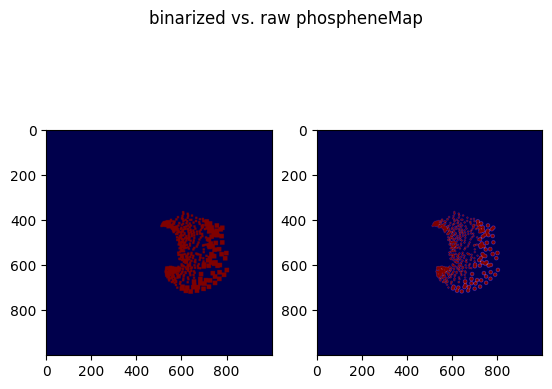

    max phospheneMap:  0.00045396722
target:  targ-full
loss:  dice-yield-HD
a,b,c:  1 0.1 1
     2.70 0.14 0.50 0.90 True
     2.87 0.04 0.36 0.94 True
     2.88 0.04 0.24 0.94 True
map is nan or 0
Hellington is nan or inf
     2.99 0.00 0.12 1.00 True
     3.70 0.00 0.43 0.99 False
     3.57 0.07 0.34 0.92 False
     2.85 0.05 0.33 0.93 True
     2.91 0.02 0.35 0.96 True
     2.75 0.10 0.42 0.89 True
     3.56 0.07 0.32 0.92 False
     2.83 0.07 0.18 0.92 True
     2.57 0.23 0.43 0.84 True
     3.69 0.01 0.27 0.97 False
     2.60 0.21 0.41 0.85 True
     2.88 0.03 0.33 0.95 True
     3.56 0.07 0.38 0.92 False
     2.73 0.12 0.35 0.89 True
     2.78 0.09 0.36 0.90 True
     2.86 0.04 0.39 0.94 True
     2.64 0.19 0.36 0.87 True
     2.75 0.11 0.40 0.91 True
     2.57 0.23 0.41 0.84 True
     2.77 0.09 0.42 0.90 True
     2.58 0.22 0.41 0.85 True
     2.52 0.27 0.38 0.84 True
     2.41 0.36 0.38 0.81 True
     2.32 0.43 0.43 0.79 True
     2.35 0.41 0.41 0.80 True
     2.22 0.51 0.37 0

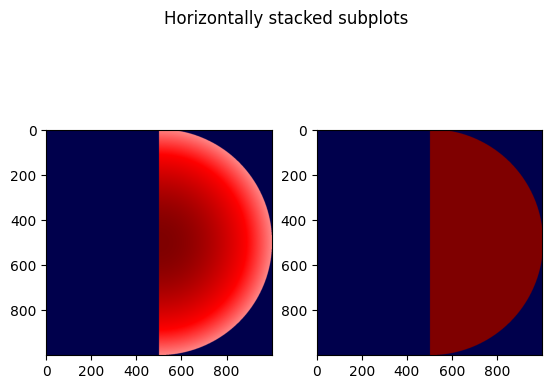

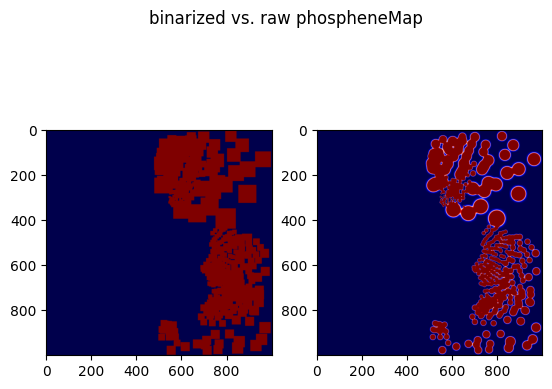

    max phospheneMap:  5.0287912e-05
     2.72 0.14 0.45 0.90 True
     2.86 0.05 0.24 0.93 True
     2.85 0.05 0.26 0.93 True
map is nan or 0
Hellington is nan or inf
     2.97 0.00 0.29 1.00 True
     2.82 0.07 0.34 0.92 True
map is nan or 0
Hellington is nan or inf
     3.74 0.00 0.14 1.00 False
     3.56 0.08 0.23 0.92 False
map is nan or 0
Hellington is nan or inf
     3.69 0.00 0.60 1.00 False
     2.74 0.11 0.43 0.89 True
     3.56 0.07 0.32 0.92 False
     3.58 0.06 0.34 0.93 False
     2.73 0.12 0.41 0.89 True
map is nan or 0
Hellington is nan or inf
     2.96 0.00 0.36 1.00 True
map is nan or 0
Hellington is nan or inf
     2.97 0.00 0.32 1.00 True
     2.45 0.34 0.41 0.83 True
     2.86 0.04 0.40 0.94 True
     3.64 0.03 0.34 0.95 False
     2.91 0.02 0.34 0.96 True
     2.83 0.06 0.35 0.93 True
     2.69 0.14 0.52 0.88 True
map is nan or 0
Hellington is nan or inf
     3.00 0.00 0.04 1.00 True
     2.80 0.08 0.35 0.92 True
     2.76 0.11 0.28 0.90 True
     2.90 0.02 0.37 0

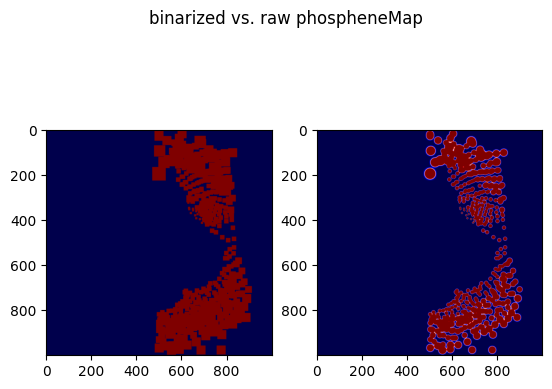

    max phospheneMap:  6.7133486e-05


In [10]:
###################
## Main Sim Loop ##
###################

# set file names
fname_ang = 'inferred_angle.mgz'
fname_ecc = 'inferred_eccen.mgz'
fname_sigma = 'inferred_sigma.mgz'
fname_anat = 'T1.mgz'
fname_aparc = 'aparc+aseg.mgz'
fname_label = 'inferred_varea.mgz'
print('number of subjects: ' + str(len(subj_list)))

# set beta angle constraints according to hemisphere
dim2_lh = Integer(name='beta', low=-15, high=110)
dim2_rh = Integer(name='beta', low=-110, high=15)

# loop through phosphene target maps and combinations of loss terms
for target_density, ftarget in zip(targ_comb, targ_names):
    for (a, b, c), floss in zip(loss_comb, loss_names):
        # set target
        target_density /= target_density.max()
        target_density /= target_density.sum()
        # can we relate bin_thesh to an eccentricity value?
        bin_thresh=np.percentile(target_density, dc_percentile ) #np.min(target_density) # bin_thesh determines size target
        target_density_bin = (target_density > bin_thresh).astype(bool)
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.suptitle('Horizontally stacked subplots')
        plt.subplot(1,2,1).imshow(target_density, cmap = 'seismic')
        plt.subplot(1,2,2).imshow(target_density_bin, cmap = 'seismic')

        for s in subj_list:
            # data_dir = datafolder + str(s)+ '/T1w/' + str(s) + '/mri/'            
            data_dir = datafolder

            if s == 'fsaverage':
                data_dir = datafolder + str(s) + '/mri/'
                
            # load maps
            ang_img = nib.load(data_dir+fname_ang)
            polar_map = ang_img.get_fdata()
            ecc_img = nib.load(data_dir+fname_ecc)
            ecc_map = ecc_img.get_fdata()
            sigma_img = nib.load(data_dir+fname_sigma)
            sigma_map = sigma_img.get_fdata()                
            aparc_img = nib.load(data_dir+fname_aparc)
            aparc_roi = aparc_img.get_fdata()
            label_img = nib.load(data_dir+fname_label)
            label_map = label_img.get_fdata()

            # compute valid voxels
            dot = (ecc_map * polar_map)
            good_coords = np.asarray(np.where(dot != 0.0))

            # filter gm per hemisphere
            cs_coords_rh = np.where(aparc_roi == 1021)
            cs_coords_lh = np.where(aparc_roi == 2021)
            gm_coords_rh = np.where((aparc_roi >= 1000) & (aparc_roi < 2000))
            gm_coords_lh = np.where(aparc_roi > 2000)
            xl,yl,zl = get_xyz(gm_coords_lh)
            xr,yr,zr = get_xyz(gm_coords_rh)
            GM_LH = np.array([xl,yl,zl]).T
            GM_RH = np.array([xr,yr,zr]).T

            # extract labels
            V1_coords_rh = np.asarray(np.where(label_map == 1))
            V1_coords_lh = np.asarray(np.where(label_map == 1))
            V2_coords_rh = np.asarray(np.where(label_map == 2))
            V2_coords_lh = np.asarray(np.where(label_map == 2))
            V3_coords_rh = np.asarray(np.where(label_map == 3))
            V3_coords_lh = np.asarray(np.where(label_map == 3))

            # divide V1 coords per hemisphere
            good_coords_lh = np.array([x for x in set(tuple(x) for x in np.round(good_coords).T) & set(tuple(x) for x in np.round(gm_coords_lh).T)]).T
            good_coords_rh = np.array([x for x in set(tuple(x) for x in np.round(good_coords).T) & set(tuple(x) for x in np.round(gm_coords_rh).T)]).T
            V1_coords_lh = np.array([x for x in set(tuple(x) for x in np.round(V1_coords_lh).T) & set(tuple(x) for x in np.round(gm_coords_lh).T)]).T
            V1_coords_rh = np.array([x for x in set(tuple(x) for x in np.round(V1_coords_rh).T) & set(tuple(x) for x in np.round(gm_coords_rh).T)]).T
            V2_coords_lh = np.array([x for x in set(tuple(x) for x in np.round(V2_coords_lh).T) & set(tuple(x) for x in np.round(gm_coords_lh).T)]).T
            V2_coords_rh = np.array([x for x in set(tuple(x) for x in np.round(V2_coords_rh).T) & set(tuple(x) for x in np.round(gm_coords_rh).T)]).T
            V3_coords_lh = np.array([x for x in set(tuple(x) for x in np.round(V3_coords_lh).T) & set(tuple(x) for x in np.round(gm_coords_lh).T)]).T
            V3_coords_rh = np.array([x for x in set(tuple(x) for x in np.round(V3_coords_rh).T) & set(tuple(x) for x in np.round(gm_coords_rh).T)]).T           

            # find center of left and right calcarine sulci
            median_lh = [np.median(cs_coords_lh[0][:]), np.median(cs_coords_lh[1][:]), np.median(cs_coords_lh[2][:])]
            median_rh = [np.median(cs_coords_rh[0][:]), np.median(cs_coords_rh[1][:]), np.median(cs_coords_rh[2][:])]

            # get GM mask and compute dorsal/posterior planes
            gm_mask = np.where(aparc_roi != 0)
            print('target: ', ftarget)
            print('loss: ', floss)
            print('a,b,c: ', a,b,c)

            # apply optimization to each hemisphere
            for gm_mask, hem, start_location, good_coords, good_coords_V1, good_coords_V2, good_coords_V3, dim2 in zip([GM_LH, GM_RH], ['LH', 'RH'], [median_lh, median_rh], [good_coords_lh, good_coords_rh], [V1_coords_lh, V1_coords_rh], [V2_coords_lh, V2_coords_rh], [V3_coords_lh, V3_coords_rh], [dim2_lh, dim2_rh]):        
                
                # check if already done
                data_id = str(s) + '_' + str(hem) + '_V1_n1000_1x10_' + floss + '_' + str(thresh) + '_' + ftarget
                fname = outputfolder + data_id + '.pkl'
                if os.path.exists(fname):
                    print(str(s), ' ', str(hem), ' ',  str(ftarget), ' ', str(floss), ' already processed.')
                else:
                    dimensions = [dim1, dim2, dim3, dim4]

                    # create initial point generator
                    lhs2 = cook_initial_point_generator("lhs", criterion="maximin")

                    # optimize
                    res = gp_minimize(f, x0=x0, dimensions=dimensions, n_jobs=-1, n_calls=num_calls, n_initial_points=num_initial_points, initial_point_generator=lhs2, callback=[custom_stopper])

                    # print results
                    # print('subject ', s, ' ', hem)
                    # print('best alpha:', res.x[0])
                    # print('best beta:',res.x[1])
                    # print('best offset_from_base:', res.x[2])
                    # print('best shank_length:',res.x[3])
                    print('subject ', s, ' ', hem, ', best alpha: ', res.x[0], ', best beta: ', res.x[1], ', best offset_from_base: ', res.x[2], ', best shank_length: ', res.x[3])
                    grid_valid, dice, hell_d, grid_yield, phosphenes, phosphenes_V1, phosphenes_V2, phosphenes_V3, contacts_xyz_moved, phospheneMap = f_manual(res.x[0], res.x[1],res.x[2], res.x[3], good_coords, good_coords_V1, good_coords_V2, good_coords_V3, target_density)
                    print('best dice, yield, KL: ', dice, grid_yield, hell_d)

                    # show resulting binary phosphene map (reflects dice coefficient)
                    bin_thresh=np.percentile(phospheneMap, dc_percentile) #np.min(target_density) # bin_thesh determines size target
                    phospheneMap_bin = (phospheneMap > bin_thresh).astype(bool)
                    fig, (ax1, ax2) = plt.subplots(1, 2)
                    fig.suptitle('binarized vs. raw phospheneMap')
                    plt.subplot(1,2,1).imshow(phospheneMap_bin, cmap = 'seismic', vmin=0, vmax=np.max(phospheneMap)/100)
                    plt.subplot(1,2,2).imshow(phospheneMap, cmap = 'seismic', vmin=0, vmax=np.max(phospheneMap)/100)
                    plt.show()
                    print('    max phospheneMap: ', np.max(phospheneMap))        

                    # Saving the objects
                    data_id = str(s) + '_' + str(hem) + '_V1_n1000_1x10_' + floss + '_' + str(thresh) + '_' + ftarget                    
                    fname = outputfolder + data_id + '.pkl'
                    with open(fname, 'wb') as file:
                        pickle.dump([res, 
                                     grid_valid, 
                                     dice, hell_d, 
                                     grid_yield, 
                                     contacts_xyz_moved,
                                     good_coords,
                                     good_coords_V1,
                                     good_coords_V2,
                                     good_coords_V3,
                                     phosphenes,
                                     phosphenes_V1,
                                     phosphenes_V2,
                                     phosphenes_V3], file, protocol=-1)

Loaded: 102311_RH_V1_n1000_1x10_dice-yield-HD_0.05_targ-full.pkl
contacts_xyz_moved shape: (3, 1000)
phosphenes_V1 shape: (475, 3)
[  1/100]  Dice=0.037  Yield=1.000  H=0.920  Sim=0.217
[ 10/100]  Dice=0.238  Yield=1.000  H=0.798  Sim=0.540
[ 20/100]  Dice=0.358  Yield=1.000  H=0.757  Sim=0.700
[ 30/100]  Dice=0.450  Yield=1.000  H=0.723  Sim=0.828
[ 40/100]  Dice=0.508  Yield=1.000  H=0.684  Sim=0.924
[ 50/100]  Dice=0.558  Yield=1.000  H=0.652  Sim=1.006
[ 60/100]  Dice=0.603  Yield=1.000  H=0.621  Sim=1.082
[ 70/100]  Dice=0.644  Yield=1.000  H=0.594  Sim=1.150
[ 80/100]  Dice=0.682  Yield=1.000  H=0.570  Sim=1.212
[ 90/100]  Dice=0.717  Yield=1.000  H=0.549  Sim=1.268
[100/100]  Dice=0.746  Yield=1.000  H=0.528  Sim=1.318

Final
Selected=100  Dice=0.7459  Yield=1.0000  H=0.5282  Similarity=1.3178


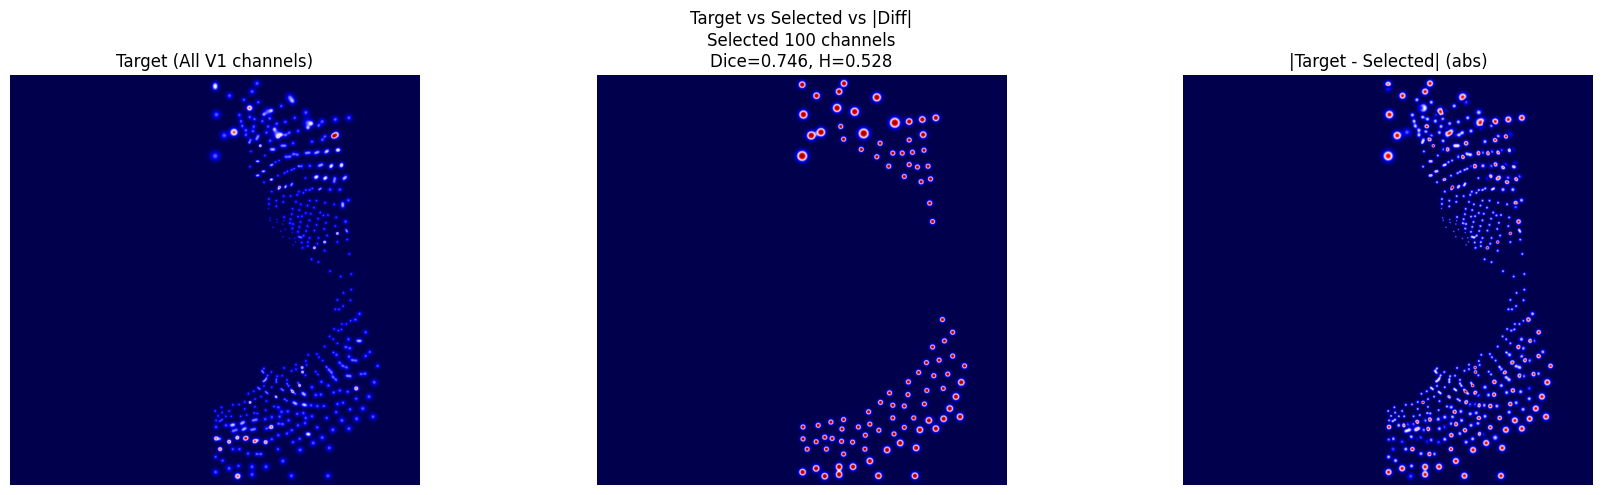

Saved: C:\Users\user\YongtaeC\vimplant0812\data\output\102311\greedy_selected_100.npz


In [ ]:
# -*- coding: utf-8 -*-
# Greedy forward selection (100 channels) to match the full-map (built from all V1-mapped phosphenes)
# Subject: 102311 RH  (pickle already contains best solution outputs)
import os, pickle
import numpy as np
import matplotlib.pyplot as plt

from lossfunc import DC, hellinger_distance
from electphos import prf_to_phos

PICKLE_PATH  = r"C:\Users\user\YongtaeC\vimplant0812\data\output\102311\102311_RH_V1_n1000_1x10_dice-yield-HD_0.05_targ-full.pkl"
WINDOWSIZE   = 1000
VIEW_ANGLE   = 90
DC_PERCENTILE = 50

# Van Hoof-style similarity weights (Yield는 본 버전에서 상수 1.0으로 처리)
a, b, c = 1.0, 0.1, 1.0
K_SELECT_TARGET = 100

def normalize_pdf(x, eps=1e-12):
    x = np.clip(x, 0, None).astype(np.float32)
    s = float(x.sum())
    return x / (s + eps)

def single_map_raw(phosphenes_block):
    """
    phosphenes_block: (k, 3) array [[angle, ecc, sigma], ...]
    반환: 정규화(없음) raw map (WINDOWSIZE x WINDOWSIZE)
    """
    pm = np.zeros((WINDOWSIZE, WINDOWSIZE), dtype=np.float32)
    if phosphenes_block.size == 0:
        return pm
    pm = prf_to_phos(pm, phosphenes_block, view_angle=VIEW_ANGLE, phSizeScale=1)
    return pm  # raw (not normalized)

def dice_hellinger_similarity(target_pdf, cand_pdf, bin_thresh):
    dice, _, _ = DC(target_pdf, cand_pdf, bin_thresh)
    H = float(hellinger_distance(cand_pdf.flatten(), target_pdf.flatten()))
    # Yield는 phosphenes_V1에서 선택하므로 1.0으로 간주(상수 → 순위에 영향 없음)
    y = 1.0
    sim = a * dice + b * y + c * (1.0 - H)
    return dice, y, H, sim

# ---------- Load ----------
with open(PICKLE_PATH, "rb") as f:
    (res, grid_valid, dice_best, hell_d_best, grid_yield_best,
     contacts_xyz_moved, good_coords, good_coords_V1, good_coords_V2, good_coords_V3,
     phosphenes, phosphenes_V1, phosphenes_V2, phosphenes_V3) = pickle.load(f)

print("Loaded:", os.path.basename(PICKLE_PATH))
print("contacts_xyz_moved shape:", np.asarray(contacts_xyz_moved).shape)
print("phosphenes_V1 shape:", phosphenes_V1.shape)

# ---------- 후보 세트: V1에 매핑된 phosphenes (행마다 하나의 채널로 취급) ----------
M = phosphenes_V1.shape[0]
candidate_idx = []
single_cache_raw = {}

# 유효 후보 선별: 단일맵이 완전히 0이 아닌 채널만
for i in range(M):
    pm_i = single_cache_raw.get(i)
    if pm_i is None:
        pm_i = single_map_raw(phosphenes_V1[i:i+1, :])
        single_cache_raw[i] = pm_i
    if pm_i.sum() > 0:
        candidate_idx.append(i)

candidate_idx = np.array(candidate_idx, dtype=int)
if candidate_idx.size == 0:
    raise RuntimeError("유효한 V1 phosphenes 후보가 없습니다.")

# ---------- 타깃 맵(= 모든 후보를 켠 맵) ----------
target_pm_raw = np.zeros((WINDOWSIZE, WINDOWSIZE), dtype=np.float32)
for i in candidate_idx:
    target_pm_raw += single_cache_raw[i]
target_pdf = normalize_pdf(target_pm_raw)

BIN_THRESH = np.percentile(target_pdf, DC_PERCENTILE)

# ---------- Greedy forward selection ----------
K_SELECT = min(K_SELECT_TARGET, candidate_idx.size)
selected = []
current_pm_raw = np.zeros_like(target_pm_raw)
remaining = set(candidate_idx.tolist())

for step in range(1, K_SELECT + 1):
    best_sim, best_i = -1e9, None
    for i in list(remaining):
        cand_pm_raw = current_pm_raw + single_cache_raw[i]
        cand_pdf = normalize_pdf(cand_pm_raw)
        d, y, h, sim = dice_hellinger_similarity(target_pdf, cand_pdf, BIN_THRESH)
        if sim > best_sim:
            best_sim, best_i = sim, i

    # commit
    selected.append(best_i)
    remaining.remove(best_i)
    current_pm_raw += single_cache_raw[best_i]

    if step % 10 == 0 or step in (1, K_SELECT):
        cand_pdf = normalize_pdf(current_pm_raw)
        d, y, h, sim = dice_hellinger_similarity(target_pdf, cand_pdf, BIN_THRESH)
        print(f"[{step:3d}/{K_SELECT}]  Dice={d:.3f}  Yield={y:.3f}  H={h:.3f}  Sim={sim:.3f}")

# ---------- Final metrics & viz ----------
selected_pdf = normalize_pdf(current_pm_raw)
dice_sel, y_sel, H_sel, sim_sel = dice_hellinger_similarity(target_pdf, selected_pdf, BIN_THRESH)
print("\nFinal")
print(f"Selected={len(selected)}  Dice={dice_sel:.4f}  Yield={y_sel:.4f}  H={H_sel:.4f}  Similarity={sim_sel:.4f}")

diff_pm = np.abs(target_pdf - selected_pdf)

fig, axs = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle("Target vs Selected vs |Diff|", fontsize=12)

axs[0].imshow(target_pdf, cmap="seismic")
axs[0].set_title("Target (All V1 channels)")

axs[1].imshow(selected_pdf, cmap="seismic")
axs[1].set_title(f"Selected {len(selected)} channels\nDice={dice_sel:.3f}, H={H_sel:.3f}")

axs[2].imshow(diff_pm, cmap="seismic")
axs[2].set_title("|Target - Selected| (abs)")

for ax in axs: 
    ax.axis("off")

plt.tight_layout()
plt.subplots_adjust(top=0.85)

out_dir = os.path.dirname(PICKLE_PATH)
png_path = os.path.join(out_dir, f"greedy_selected_{len(selected)}.png")
plt.savefig(png_path, dpi=200, bbox_inches="tight")
plt.show()
plt.close(fig)

# # ---------- Save ----------
# out_dir = os.path.dirname(PICKLE_PATH)
# np.savez(os.path.join(out_dir, f"greedy_selected_{len(selected)}.npz"),
#          selected=np.array(selected, dtype=int),
#          target_pdf=target_pdf.astype(np.float32),
#          selected_pdf=selected_pdf.astype(np.float32),
#          diff_pm=diff_pm.astype(np.float32))
# print("Saved:", os.path.join(out_dir, f"greedy_selected_{len(selected)}.npz"))


Loaded: 102311_RH_V1_n1000_1x10_dice-yield-HD_0.05_targ-full.pkl
phosphenes_V1 shape: (475, 3)
Valid V1-mapped channels: 468 / 475
Downsampled feature matrix X: (10000, 468) (F_ds x n_ch)
Selected 100 by leverage scores.

Final (CSSP)
Dice=0.3307  H=0.7197  Similarity=0.6110
Note: Yield treated as constant (1.0) because phosphenes_V1 is already V1-mapped subset.


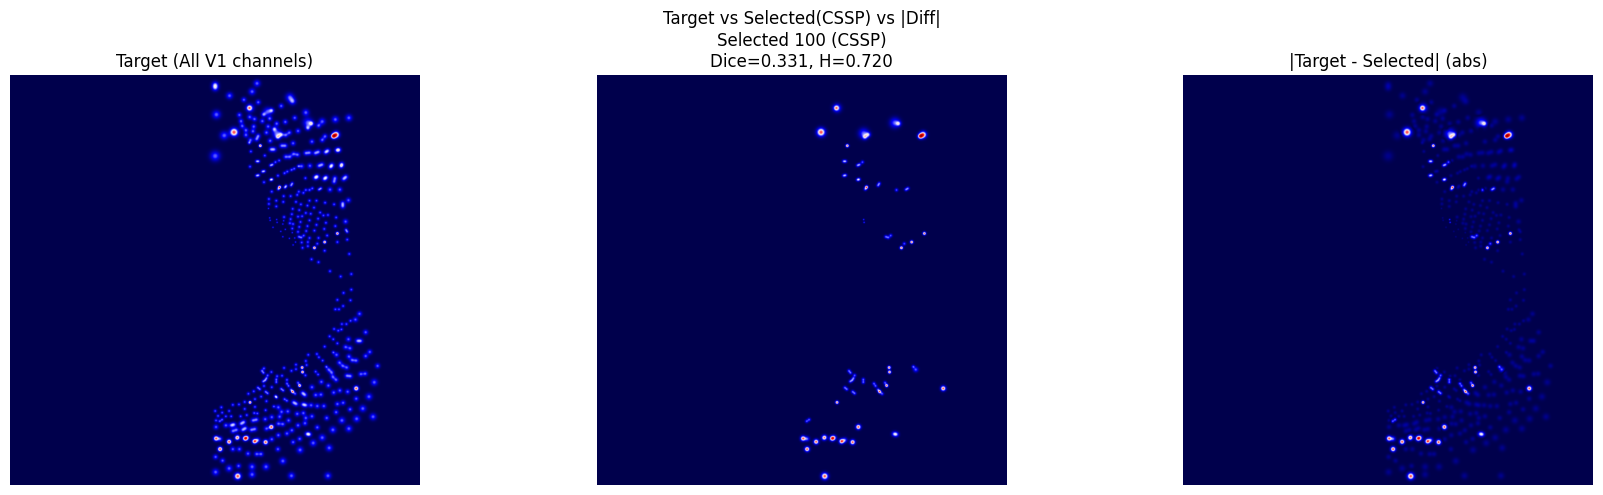

Saved PNG: C:\Users\user\YongtaeC\vimplant0812\data\output\102311\cssp_selected_100.png
Saved NPZ: C:\Users\user\YongtaeC\vimplant0812\data\output\102311\cssp_selected_100.npz


In [ ]:
# -*- coding: utf-8 -*-
# Column Subset Selection (CSSP) with leverage scores using randomized SVD
# Select 100 channels that best represent the "full-map" (all V1-mapped channels)
# Subject: 102311 RH, pickle already contains best solution outputs
# File: C:\Users\user\YongtaeC\vimplant0812\data\output\102311\102311_RH_V1_n1000_1x10_dice-yield-HD_0.05_targ-full.pkl

import os, pickle
import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils.extmath import randomized_svd  # efficient for tall matrices
from lossfunc import DC, hellinger_distance
from electphos import prf_to_phos

# -----------------
# Config
# -----------------
PICKLE_PATH   = r"C:\Users\user\YongtaeC\vimplant0812\data\output\102311\102311_RH_V1_n1000_1x10_dice-yield-HD_0.05_targ-full.pkl"

WINDOWSIZE    = 1000     # original sim resolution
VIEW_ANGLE    = 90
DC_PERCENTILE = 50

# CSSP hyperparams
DOWNSAMPLE    = 10       # 1000 -> 100 (average pooling)
RANK_K        = 32       # number of right singular vectors for leverage scores (typ. 16~64)
K_SELECT_TGT  = 100      # select top-100 channels

# Van Hoof-style (Yield는 phosphenes_V1 기반이므로 상수로 간주)
a, b = 1.0, 1.0  # a for Dice, b for (1 - H). (Yield is treated as 1.0 -> 가중 영향 없음)

# -----------------
# Helpers
# -----------------
def normalize_pdf(x, eps=1e-12):
    x = np.clip(x, 0, None).astype(np.float32)
    s = float(x.sum())
    return x / (s + eps)

def single_map_raw(phosphenes_block):
    """
    phosphenes_block: (k, 3) array [[angle, ecc, sigma], ...]
    return raw (non-normalized) phosphene map at WINDOWSIZE x WINDOWSIZE
    """
    pm = np.zeros((WINDOWSIZE, WINDOWSIZE), dtype=np.float32)
    if phosphenes_block.size == 0:
        return pm
    pm = prf_to_phos(pm, phosphenes_block, view_angle=VIEW_ANGLE, phSizeScale=1)
    return pm  # raw

def downsample_avg(img, factor=DOWNSAMPLE):
    """Average pooling downsampling: (H,W)->(H/f,W/f). Assumes H,W divisible by f."""
    H, W = img.shape
    assert H % factor == 0 and W % factor == 0, "Image size must be divisible by factor"
    h, w = H // factor, W // factor
    return img.reshape(h, factor, w, factor).mean(axis=(1, 3))

def dice_hellinger_similarity(target_pdf, cand_pdf, bin_thresh):
    dice, _, _ = DC(target_pdf, cand_pdf, bin_thresh)
    H = float(hellinger_distance(cand_pdf.flatten(), target_pdf.flatten()))
    # Yield는 phosphenes_V1 후보로 제한되어 상수(=1.0)로 처리
    sim = a * dice + b * (1.0 - H)
    return dice, H, sim

# -----------------
# Load pickle
# -----------------
with open(PICKLE_PATH, "rb") as f:
    (res, grid_valid, dice_best, hell_d_best, grid_yield_best,
     contacts_xyz_moved, good_coords, good_coords_V1, good_coords_V2, good_coords_V3,
     phosphenes, phosphenes_V1, phosphenes_V2, phosphenes_V3) = pickle.load(f)

print("Loaded:", os.path.basename(PICKLE_PATH))
print("phosphenes_V1 shape:", phosphenes_V1.shape)

# -----------------
# Build candidate set from V1-mapped phosphenes
# -----------------
M = phosphenes_V1.shape[0]
candidate_idx = []
single_cache_raw = {}

for i in range(M):
    pm_i = single_cache_raw.get(i)
    if pm_i is None:
        pm_i = single_map_raw(phosphenes_V1[i:i+1, :])
        single_cache_raw[i] = pm_i
    if pm_i.sum() > 0:
        candidate_idx.append(i)

candidate_idx = np.array(candidate_idx, dtype=int)
if candidate_idx.size == 0:
    raise RuntimeError("유효한 V1 phosphenes 후보가 없습니다.")
print(f"Valid V1-mapped channels: {candidate_idx.size} / {M}")

# -----------------
# Target map = sum of all candidate channels (normalized PDF)
# -----------------
target_pm_raw = np.zeros((WINDOWSIZE, WINDOWSIZE), dtype=np.float32)
for i in candidate_idx:
    target_pm_raw += single_cache_raw[i]
target_pdf = normalize_pdf(target_pm_raw)
BIN_THRESH = np.percentile(target_pdf, DC_PERCENTILE)

# -----------------
# Build feature matrix X (F x n) via average pooling downsample
#   columns = channels, rows = pooled pixels
#   column L2-normalization for stable leverage estimation
# -----------------
ds_target = downsample_avg(target_pm_raw, DOWNSAMPLE)  # just for info/scale (not used in X)
h_ds, w_ds = ds_target.shape
F_ds = h_ds * w_ds
n_ch = candidate_idx.size

X = np.zeros((F_ds, n_ch), dtype=np.float32)

for j, ch in enumerate(candidate_idx):
    pm_raw = single_cache_raw[ch]
    pm_ds  = downsample_avg(pm_raw, DOWNSAMPLE)
    v = pm_ds.reshape(-1)
    # column scaling: L2 normalize unless all-zero
    norm = np.linalg.norm(v)
    if norm > 0:
        v = v / norm
    X[:, j] = v

print("Downsampled feature matrix X:", X.shape, "(F_ds x n_ch)")

# -----------------
# Leverage scores via randomized SVD
#   X = U Σ V^T, with X in R^{F x n}
#   Column leverage for channel j: l_j = ||V_k(j,:)||^2
# -----------------
k = min(RANK_K, n_ch - 1) if n_ch > 1 else 1
U, S, VT = randomized_svd(X, n_components=k, n_iter=5, random_state=42)
V_k = VT.T   # (n_ch x k)
lev_scores = np.sum(V_k**2, axis=1)  # (n_ch,)

# Top-K channels by leverage
K_SELECT = min(K_SELECT_TGT, n_ch)
order = np.argsort(-lev_scores)  # descending
selected_local_idx = order[:K_SELECT]          # indices in [0..n_ch)
selected_channels  = candidate_idx[selected_local_idx]  # original indices in phosphenes_V1

print(f"Selected {K_SELECT} by leverage scores.")

# -----------------
# Compose selected map and compute metrics
# -----------------
selected_pm_raw = np.zeros_like(target_pm_raw)
for ch in selected_channels:
    selected_pm_raw += single_cache_raw[ch]
selected_pdf = normalize_pdf(selected_pm_raw)

dice_sel, H_sel, sim_sel = dice_hellinger_similarity(target_pdf, selected_pdf, BIN_THRESH)
print("\nFinal (CSSP)")
print(f"Dice={dice_sel:.4f}  H={H_sel:.4f}  Similarity={sim_sel:.4f}")
print("Note: Yield treated as constant (1.0) because phosphenes_V1 is already V1-mapped subset.")

# -----------------
# Visualization (vimplant-like, 'seismic') + PNG save
# -----------------
diff_pm = np.abs(target_pdf - selected_pdf)

fig, axs = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle("Target vs Selected(CSSP) vs |Diff|", fontsize=12)

axs[0].imshow(target_pdf, cmap="seismic")
axs[0].set_title("Target (All V1 channels)")

axs[1].imshow(selected_pdf, cmap="seismic")
axs[1].set_title(f"Selected {K_SELECT} (CSSP)\nDice={dice_sel:.3f}, H={H_sel:.3f}")

axs[2].imshow(diff_pm, cmap="seismic")
axs[2].set_title("|Target - Selected| (abs)")

for ax in axs: ax.axis("off")
plt.tight_layout()
plt.subplots_adjust(top=0.85)

out_dir = os.path.dirname(PICKLE_PATH)
png_path = os.path.join(out_dir, f"cssp_selected_{K_SELECT}.png")
plt.savefig(png_path, dpi=200, bbox_inches="tight")
plt.show()
plt.close(fig)

# -----------------
# Save selection & maps
# -----------------
np.savez(os.path.join(out_dir, f"cssp_selected_{K_SELECT}.npz"),
         selected=selected_channels.astype(int),
         target_pdf=target_pdf.astype(np.float32),
         selected_pdf=selected_pdf.astype(np.float32),
         diff_pm=diff_pm.astype(np.float32),
         leverage_scores=lev_scores.astype(np.float32),
         candidate_idx=candidate_idx.astype(int))

print("Saved PNG:", png_path)
# print("Saved NPZ:", os.path.join(out_dir, f"cssp_selected_{K_SELECT}.npz"))


Loaded: 102311_RH_V1_n1000_1x10_dice-yield-HD_0.05_targ-full.pkl
phosphenes_V1 shape: (475, 3)
Valid V1-mapped channels: 468 / 475
CSSP seed selected 100 channels.
Initial (CSSP)  Dice=0.3307  H=0.7197  Sim=0.6110
[Swap 001]  out=133 in=452  ->  Dice=0.3372  H=0.7160  Sim=0.621170  (+0.010170)
[Swap 002]  out=436 in=81  ->  Dice=0.3433  H=0.7121  Sim=0.631189  (+0.010019)
[Swap 003]  out=336 in=417  ->  Dice=0.3496  H=0.7088  Sim=0.640844  (+0.009655)
[Swap 004]  out=446 in=69  ->  Dice=0.3608  H=0.7033  Sim=0.657581  (+0.016736)
[Swap 005]  out=141 in=252  ->  Dice=0.3671  H=0.6997  Sim=0.667388  (+0.009807)
[Swap 006]  out=132 in=441  ->  Dice=0.3733  H=0.6965  Sim=0.676791  (+0.009403)
[Swap 007]  out=201 in=440  ->  Dice=0.3794  H=0.6933  Sim=0.686119  (+0.009327)
[Swap 008]  out=97 in=434  ->  Dice=0.3848  H=0.6902  Sim=0.694539  (+0.008421)
[Swap 009]  out=324 in=140  ->  Dice=0.3894  H=0.6866  Sim=0.702773  (+0.008233)
[Swap 010]  out=215 in=449  ->  Dice=0.3929  H=0.6832  Sim=0

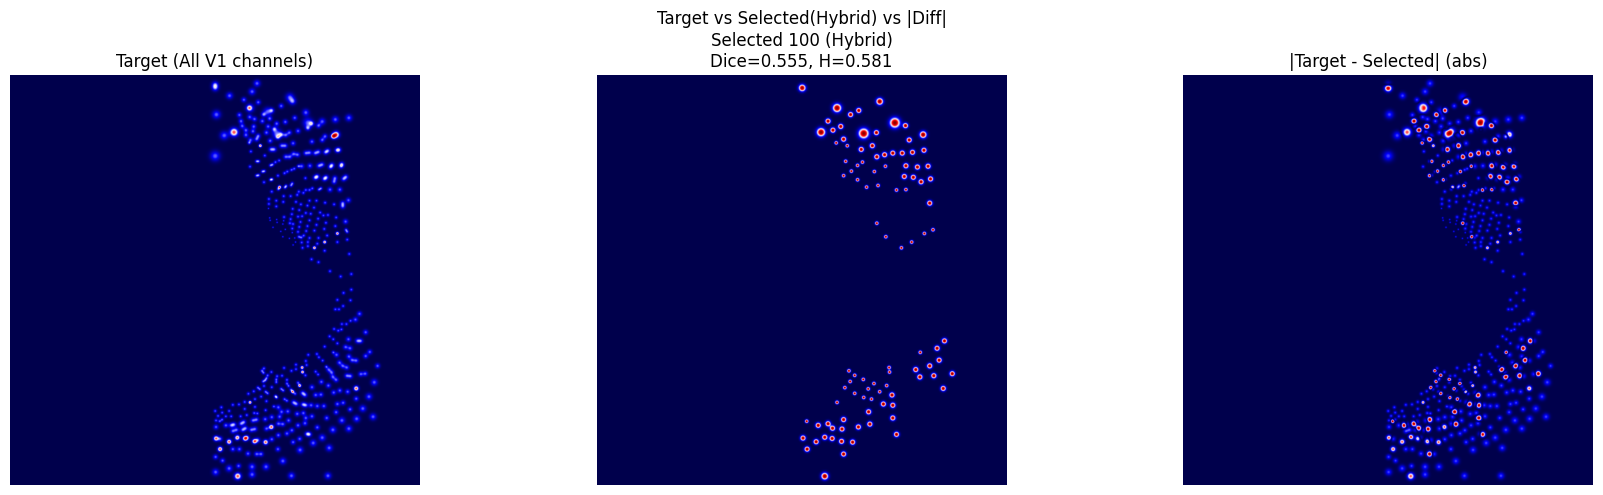

Saved PNG: C:\Users\user\YongtaeC\vimplant0812\data\output\102311\hybrid_selected_100.png
Saved NPZ: C:\Users\user\YongtaeC\vimplant0812\data\output\102311\hybrid_selected_100.npz


In [ ]:
# -*- coding: utf-8 -*-
# Hybrid: CSSP (leverage via randomized SVD) seed -> Greedy 1-1 swap refinement
# Subject: 102311 RH; pickle already contains best solution outputs
# Pickle: C:\Users\user\YongtaeC\vimplant0812\data\output\102311\102311_RH_V1_n1000_1x10_dice-yield-HD_0.05_targ-full.pkl

import os, pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.extmath import randomized_svd

from lossfunc import DC, hellinger_distance
from electphos import prf_to_phos

# -----------------
# Config
# -----------------
PICKLE_PATH   = r"C:\Users\user\YongtaeC\vimplant0812\data\output\102311\102311_RH_V1_n1000_1x10_dice-yield-HD_0.05_targ-full.pkl"

WINDOWSIZE    = 1000
VIEW_ANGLE    = 90
DC_PERCENTILE = 50

# CSSP (seed) hyperparams
DOWNSAMPLE    = 10        # 1000 -> 100 (avg pooling)
RANK_K        = 32        # leverage rank (16~64 권장)
K_SELECT_TGT  = 100

# Greedy swap refinement
MAX_SWAPS     = 200       # 최대 스왑 시도 횟수
IMPROVE_TOL   = 1e-5      # 개선 최소 폭
ADD_POOL_TOP  = 5        # 추가 후보 상위 N(잔차 상관 기준)
REM_POOL_ALL  = True      # 제거 후보 전부 시도(True) / 상위 일부만(False)

# Van Hoof-style weights (Yield는 상수 취급)
A_DICE = 1.0
B_1mH  = 1.0

# -----------------
# Helpers
# -----------------
def normalize_pdf(x, eps=1e-12):
    x = np.clip(x, 0, None).astype(np.float32)
    s = float(x.sum())
    return x / (s + eps)

def single_map_raw(phosphenes_block):
    """Return raw (non-normalized) phosphene map at WINDOWSIZE x WINDOWSIZE."""
    pm = np.zeros((WINDOWSIZE, WINDOWSIZE), dtype=np.float32)
    if phosphenes_block.size == 0:
        return pm
    pm = prf_to_phos(pm, phosphenes_block, view_angle=VIEW_ANGLE, phSizeScale=1)
    return pm  # raw

def downsample_avg(img, factor):
    H, W = img.shape
    assert H % factor == 0 and W % factor == 0, "Image size must be divisible by factor"
    h, w = H // factor, W // factor
    return img.reshape(h, factor, w, factor).mean(axis=(1, 3))

def dice_hellinger_similarity(target_pdf, cand_pdf, bin_thresh):
    dice, _, _ = DC(target_pdf, cand_pdf, bin_thresh)
    H = float(hellinger_distance(cand_pdf.flatten(), target_pdf.flatten()))
    sim = A_DICE * dice + B_1mH * (1.0 - H)
    return dice, H, sim

# -----------------
# Load pickle
# -----------------
with open(PICKLE_PATH, "rb") as f:
    (res, grid_valid, dice_best, hell_d_best, grid_yield_best,
     contacts_xyz_moved, good_coords, good_coords_V1, good_coords_V2, good_coords_V3,
     phosphenes, phosphenes_V1, phosphenes_V2, phosphenes_V3) = pickle.load(f)

print("Loaded:", os.path.basename(PICKLE_PATH))
print("phosphenes_V1 shape:", phosphenes_V1.shape)

# -----------------
# Build candidate set (V1-mapped phosphenes with nonzero single-map)
# -----------------
M = phosphenes_V1.shape[0]
candidate_idx = []
single_cache_raw = {}

for i in range(M):
    pm_i = single_cache_raw.get(i)
    if pm_i is None:
        pm_i = single_map_raw(phosphenes_V1[i:i+1, :])
        single_cache_raw[i] = pm_i
    if pm_i.sum() > 0:
        candidate_idx.append(i)

candidate_idx = np.array(candidate_idx, dtype=int)
if candidate_idx.size == 0:
    raise RuntimeError("유효한 V1 phosphenes 후보가 없습니다.")
print(f"Valid V1-mapped channels: {candidate_idx.size} / {M}")

# -----------------
# Target map (PDF)
# -----------------
target_pm_raw = np.zeros((WINDOWSIZE, WINDOWSIZE), dtype=np.float32)
for ch in candidate_idx:
    target_pm_raw += single_cache_raw[ch]
target_pdf = normalize_pdf(target_pm_raw)
BIN_THRESH = np.percentile(target_pdf, DC_PERCENTILE)

# -----------------
# CSSP seed via leverage scores (randomized SVD on downsampled column-normalized X)
# -----------------
h_ds, w_ds = (WINDOWSIZE // DOWNSAMPLE, WINDOWSIZE // DOWNSAMPLE)
F_ds = h_ds * w_ds
n_ch = candidate_idx.size

X = np.zeros((F_ds, n_ch), dtype=np.float32)
for j, ch in enumerate(candidate_idx):
    pm_ds = downsample_avg(single_cache_raw[ch], DOWNSAMPLE)
    v = pm_ds.reshape(-1)
    nrm = np.linalg.norm(v)
    if nrm > 0:
        v = v / nrm
    X[:, j] = v

k = min(max(1, RANK_K), max(1, n_ch - 1))
U, S, VT = randomized_svd(X, n_components=k, n_iter=5, random_state=42)
V_k = VT.T
lev_scores = np.sum(V_k**2, axis=1)  # (n_ch,)

K_SELECT = min(K_SELECT_TGT, n_ch)
order = np.argsort(-lev_scores)
selected_local = order[:K_SELECT]
selected = candidate_idx[selected_local].tolist()
print(f"CSSP seed selected {len(selected)} channels.")

# Compose current map/raw
current_pm_raw = np.zeros_like(target_pm_raw)
for ch in selected:
    current_pm_raw += single_cache_raw[ch]

# -----------------
# Greedy 1-1 swap refinement (hill climbing)
# -----------------
def compute_metrics(raw_map):
    pdf = normalize_pdf(raw_map)
    d, h, s = dice_hellinger_similarity(target_pdf, pdf, BIN_THRESH)
    return d, h, s, pdf

dice_cur, H_cur, sim_cur, current_pdf = compute_metrics(current_pm_raw)
print(f"Initial (CSSP)  Dice={dice_cur:.4f}  H={H_cur:.4f}  Sim={sim_cur:.4f}")

selected_set = set(selected)
remaining_set = set(candidate_idx.tolist()) - selected_set

for it in range(1, MAX_SWAPS + 1):
    # 잔차(타깃-현맵)에 가장 상관 높은 추가 후보 상위 ADD_POOL_TOP 추리기
    residual = target_pdf - current_pdf  # PDF 공간에서 근사 지표
    # 각 미선택 채널과 residual의 상관치(내적) 계산
    add_scores = []
    for ch in remaining_set:
        v = normalize_pdf(single_cache_raw[ch])  # PDF로 근사
        add_scores.append((ch, float((v * residual).sum())))
    add_scores.sort(key=lambda x: -x[1])
    add_pool = [ch for ch, _ in add_scores[:min(ADD_POOL_TOP, len(add_scores))]]

    # 제거 후보: 전체 or 기여도 낮은 일부 (여기서는 전체)
    rem_pool = list(selected_set) if REM_POOL_ALL else list(selected_set)[:20]

    best_gain = 0.0
    best_pair = None
    best_raw = None
    best_pdf  = None
    best_metrics = None

    for r in rem_pool:
        map_r = single_cache_raw[r]
        # 미리 제거한 상태의 raw (가속)
        base_raw = current_pm_raw - map_r
        for a in add_pool:
            if a == r: 
                continue
            map_a = single_cache_raw[a]
            cand_raw = base_raw + map_a
            d, h, s, cand_pdf = compute_metrics(cand_raw)
            gain = s - sim_cur
            if gain > best_gain + 1e-12:
                best_gain = gain
                best_pair = (r, a)
                best_raw = cand_raw
                best_pdf = cand_pdf
                best_metrics = (d, h, s)

    if best_pair is None or best_gain < IMPROVE_TOL:
        print(f"[Swap {it:03d}] no improving swap found (gain < {IMPROVE_TOL}). Stop.")
        break

    # 적용
    r, a = best_pair
    selected_set.remove(r)
    selected_set.add(a)
    remaining_set.add(r)
    remaining_set.remove(a)

    current_pm_raw = best_raw
    current_pdf    = best_pdf
    dice_cur, H_cur, sim_cur = best_metrics
    print(f"[Swap {it:03d}]  out={r} in={a}  ->  Dice={dice_cur:.4f}  H={H_cur:.4f}  Sim={sim_cur:.6f}  (+{best_gain:.6f})")

selected = sorted(selected_set)

# -----------------
# Final metrics & visualization
# -----------------
selected_pdf = current_pdf
diff_pm = np.abs(target_pdf - selected_pdf)

print("\nFinal (Hybrid CSSP + Greedy-swap)")
print(f"Selected={len(selected)}  Dice={dice_cur:.4f}  H={H_cur:.4f}  Sim={sim_cur:.4f}")
print("Note: Yield treated as constant (=1.0) since we operate within V1-mapped set.")

# Plot (vimplant-like: seismic, 3-panels) & save
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle("Target vs Selected(Hybrid) vs |Diff|", fontsize=12)

axs[0].imshow(target_pdf, cmap="seismic"); axs[0].set_title("Target (All V1 channels)")
axs[1].imshow(selected_pdf, cmap="seismic"); axs[1].set_title(f"Selected {len(selected)} (Hybrid)\nDice={dice_cur:.3f}, H={H_cur:.3f}")
axs[2].imshow(diff_pm, cmap="seismic"); axs[2].set_title("|Target - Selected| (abs)")
for ax in axs: ax.axis("off")
plt.tight_layout(); plt.subplots_adjust(top=0.85)

out_dir = os.path.dirname(PICKLE_PATH)
png_path = os.path.join(out_dir, f"hybrid_selected_{len(selected)}.png")
plt.savefig(png_path, dpi=200, bbox_inches="tight")
plt.show(); plt.close(fig)

# # Save selection & maps
# np.savez(os.path.join(out_dir, f"hybrid_selected_{len(selected)}.npz"),
#          selected=np.array(selected, dtype=int),
#          target_pdf=target_pdf.astype(np.float32),
#          selected_pdf=selected_pdf.astype(np.float32),
#          diff_pm=diff_pm.astype(np.float32),
#          leverage_scores=lev_scores.astype(np.float32),
#          candidate_idx=candidate_idx.astype(int))
print("Saved PNG:", png_path)
# print("Saved NPZ:", os.path.join(out_dir, f"hybrid_selected_{len(selected)}.npz"))


Loaded: 102311_RH_V1_n1000_1x10_dice-yield-HD_0.05_targ-full.pkl
phosphenes_V1 shape: (475, 3)
Valid channels: 468  |  X_orig: (10000, 468) (F_ds x n_ch)
LARS support size: 97
Support adjusted to K=100
Selected 100 channels via Sparse Regression + NNLS.

Final (Sparse Regression)
Dice=0.6279  H=0.5623  Similarity=1.0656
Note: Yield treated as constant (=1.0) since we operate within V1-mapped set.


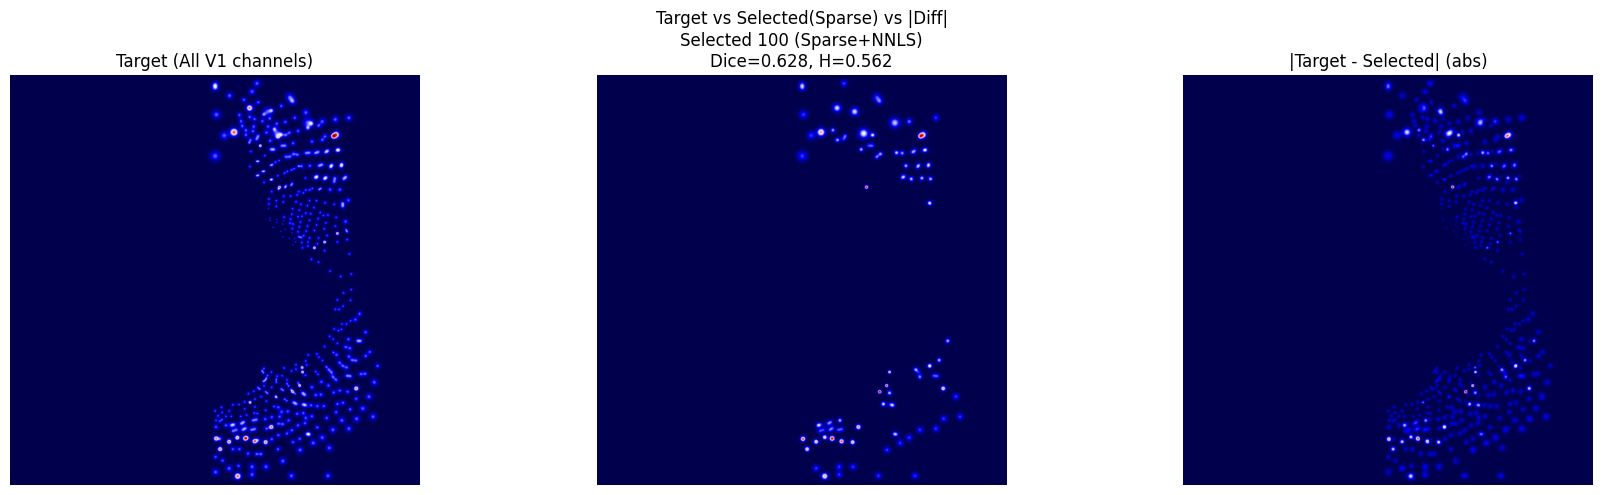

Saved PNG: C:\Users\user\YongtaeC\vimplant0812\data\output\102311\sparse_selected_100.png
Saved NPZ: C:\Users\user\YongtaeC\vimplant0812\data\output\102311\sparse_selected_100.npz


In [26]:
# -*- coding: utf-8 -*-
# Sparse Regression strategy: LARS (positive Lasso) path to pick ~100 channels,
# then NNLS refit on selected support. vimplant-like plotting & PNG/NPZ save.
#
# Subject: 102311 RH (pickle already contains best solution outputs)
# Pickle:  C:\Users\user\YongtaeC\vimplant0812\data\output\102311\102311_RH_V1_n1000_1x10_dice-yield-HD_0.05_targ-full.pkl

import os, pickle
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import lars_path
from scipy.optimize import nnls

from lossfunc import DC, hellinger_distance
from electphos import prf_to_phos

# -----------------
# Config
# -----------------
PICKLE_PATH    = r"C:\Users\user\YongtaeC\vimplant0812\data\output\102311\102311_RH_V1_n1000_1x10_dice-yield-HD_0.05_targ-full.pkl"

WINDOWSIZE     = 1000
VIEW_ANGLE     = 90
DC_PERCENTILE  = 50

# Downsample for regression feature matrix (keeps memory/time sane)
DOWNSAMPLE     = 10           # 1000 -> 100 (avg pooling) => 10k features
K_SELECT_TGT   = 100          # desired number of channels

# Van Hoof-style similarity weights (Yield는 V1 후보로 제한되어 상수 취급)
A_DICE         = 1.0
B_1mH          = 1.0

# -----------------
# Helpers
# -----------------
def normalize_pdf(x, eps=1e-12):
    x = np.clip(x, 0, None).astype(np.float32)
    s = float(x.sum())
    return x / (s + eps)

def single_map_raw(phosphenes_block):
    """Make raw (non-normalized) phosphene map at WINDOWSIZE x WINDOWSIZE."""
    pm = np.zeros((WINDOWSIZE, WINDOWSIZE), dtype=np.float32)
    if phosphenes_block.size == 0:
        return pm
    pm = prf_to_phos(pm, phosphenes_block, view_angle=VIEW_ANGLE, phSizeScale=1)
    return pm

def downsample_avg(img, factor):
    H, W = img.shape
    assert H % factor == 0 and W % factor == 0, "Image size must be divisible by factor"
    h, w = H // factor, W // factor
    return img.reshape(h, factor, w, factor).mean(axis=(1, 3))

def dice_hellinger_similarity(target_pdf, cand_pdf, bin_thresh):
    dice, _, _ = DC(target_pdf, cand_pdf, bin_thresh)
    H = float(hellinger_distance(cand_pdf.flatten(), target_pdf.flatten()))
    sim = A_DICE * dice + B_1mH * (1.0 - H)
    return dice, H, sim

# -----------------
# Load pickle
# -----------------
with open(PICKLE_PATH, "rb") as f:
    (res, grid_valid, dice_best, hell_d_best, grid_yield_best,
     contacts_xyz_moved, good_coords, good_coords_V1, good_coords_V2, good_coords_V3,
     phosphenes, phosphenes_V1, phosphenes_V2, phosphenes_V3) = pickle.load(f)

print("Loaded:", os.path.basename(PICKLE_PATH))
print("phosphenes_V1 shape:", phosphenes_V1.shape)

# -----------------
# Build candidate set & regression matrix (downsampled)
# - 메모리/속도 위해: 전체(raw) 단일맵은 타깃 합성 시 누적만 하고, 행렬은 다운샘플만 저장
# -----------------
M = phosphenes_V1.shape[0]
candidate_idx = []

# 다운샘플 피처 행렬 (10k x n_ch), 원본(정규화 전) 저장
h_ds, w_ds = (WINDOWSIZE // DOWNSAMPLE, WINDOWSIZE // DOWNSAMPLE)
F_ds = h_ds * w_ds

# 나중 NNLS 리핏 위해 '정규화 전' X_orig가 필요
X_orig = []                 # list of (F_ds,) vectors
col_norms = []             # column L2 norms (for path용 정규화)

target_pm_raw = np.zeros((WINDOWSIZE, WINDOWSIZE), dtype=np.float32)

for i in range(M):
    # 단일 전극 raw 맵
    pm_raw = single_map_raw(phosphenes_V1[i:i+1, :])
    if pm_raw.sum() <= 0:
        continue  # 기여 없는 채널 제외

    # 타깃 raw 누적
    target_pm_raw += pm_raw

    # 다운샘플 벡터 (정규화 전)
    v_ds = downsample_avg(pm_raw, DOWNSAMPLE).reshape(-1).astype(np.float32)
    X_orig.append(v_ds)
    col_norms.append(np.linalg.norm(v_ds))
    candidate_idx.append(i)

candidate_idx = np.array(candidate_idx, dtype=int)
if candidate_idx.size == 0:
    raise RuntimeError("유효한 V1 phosphenes 후보가 없습니다.")
X_orig = np.stack(X_orig, axis=1)  # (F_ds x n_ch)
col_norms = np.array(col_norms, dtype=np.float32)
print(f"Valid channels: {candidate_idx.size}  |  X_orig: {X_orig.shape} (F_ds x n_ch)")

# 타깃 PDF/임계
target_pdf = normalize_pdf(target_pm_raw)
BIN_THRESH = np.percentile(target_pdf, DC_PERCENTILE)

# -----------------
# LARS (positive Lasso) path on column-normalized features
#   X_norm = X_orig / ||x_j||_2 ; y = downsampled(target)
# -----------------
y_ds = downsample_avg(target_pm_raw, DOWNSAMPLE).reshape(-1).astype(np.float32)

eps = 1e-12
X_norm = X_orig / (col_norms + eps)  # (F_ds x n_ch)

# lars_path expects shape (n_samples, n_features) = (F_ds, n_ch)
# positive=True로 비음수 해를 구함
alphas, active, coefs = lars_path(X_norm, y_ds, method='lasso', positive=True, verbose=False)
# coefs: (n_features, n_alphas)

# nnz 수가 K_SELECT_TGT에 가장 가까운 지점 선택
nnz_counts = (np.abs(coefs) > 1e-12).sum(axis=0)
# 정확히 K가 있으면 그 인덱스, 없으면 nnz<=K 중 최댓값
target_k = min(K_SELECT_TGT, candidate_idx.size)
if np.any(nnz_counts == target_k):
    j = int(np.argmax(nnz_counts == target_k))  # 가장 이른 시점
else:
    j = int(np.argmax(nnz_counts * (nnz_counts <= target_k)))  # <=K 중 최댓값의 위치

w_path = coefs[:, j]  # (n_ch,)
support = np.where(w_path > 1e-12)[0].tolist()
print(f"LARS support size: {len(support)}")

# 만약 support < K, 잔차 상관으로 추가해서 정확히 K개 맞춤
if len(support) < target_k:
    # 잔차: y - X_norm @ w_path  (정규화 행렬 기준)
    residual = y_ds - X_norm @ w_path
    # 잔차와 상관 큰 피처 추가
    corr = X_norm.T @ residual
    add_order = np.argsort(-corr)
    for idx in add_order:
        if idx not in support:
            support.append(int(idx))
            if len(support) == target_k:
                break

# support가 K보다 크면 상위 가중치 순으로 K개
if len(support) > target_k:
    # w_path는 정규화된 행렬 기준. 절대값 큰 순으로 K개
    w_abs = np.abs(w_path[support])
    keep_idx = np.argsort(-w_abs)[:target_k]
    support = [support[i] for i in keep_idx]

print(f"Support adjusted to K={len(support)}")

# -----------------
# NNLS refit on original (non-normalized) columns for selected support
# -----------------
A = X_orig[:, support]   # (F_ds x K)
b = y_ds                 # (F_ds,)

# nnls는 하나의 b에 대해 (nonneg) 해 반환
w_nnls, _ = nnls(A, b)   # (K,)

# 선택 채널 & 가중치 (원 phosphenes_V1 인덱스)
selected_local_idx = np.array(support, dtype=int)
selected_channels  = candidate_idx[selected_local_idx]
selected_weights   = w_nnls.astype(np.float32)

print(f"Selected {selected_channels.size} channels via Sparse Regression + NNLS.")

# -----------------
# Compose selected full-res map with weights
# -----------------
selected_pm_raw = np.zeros_like(target_pm_raw)
for ch, w in zip(selected_channels, selected_weights):
    if w <= 0: 
        continue
    pm_raw = single_map_raw(phosphenes_V1[ch:ch+1, :])
    selected_pm_raw += w * pm_raw

selected_pdf = normalize_pdf(selected_pm_raw)

dice_sel, H_sel, sim_sel = dice_hellinger_similarity(target_pdf, selected_pdf, BIN_THRESH)
print("\nFinal (Sparse Regression)")
print(f"Dice={dice_sel:.4f}  H={H_sel:.4f}  Similarity={sim_sel:.4f}")
print("Note: Yield treated as constant (=1.0) since we operate within V1-mapped set.")

# -----------------
# Visualization (vimplant-like: seismic, 3-panels) + PNG save
# -----------------
diff_pm = np.abs(target_pdf - selected_pdf)

fig, axs = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle("Target vs Selected(Sparse) vs |Diff|", fontsize=12)

axs[0].imshow(target_pdf, cmap="seismic")
axs[0].set_title("Target (All V1 channels)")

axs[1].imshow(selected_pdf, cmap="seismic")
axs[1].set_title(f"Selected {selected_channels.size} (Sparse+NNLS)\nDice={dice_sel:.3f}, H={H_sel:.3f}")

axs[2].imshow(diff_pm, cmap="seismic")
axs[2].set_title("|Target - Selected| (abs)")

for ax in axs: ax.axis("off")
plt.tight_layout(); plt.subplots_adjust(top=0.85)

out_dir = os.path.dirname(PICKLE_PATH)
png_path = os.path.join(out_dir, f"sparse_selected_{selected_channels.size}.png")
plt.savefig(png_path, dpi=200, bbox_inches="tight")
plt.show(); plt.close(fig)

# -----------------
# Save selection & maps
# -----------------
np.savez(os.path.join(out_dir, f"sparse_selected_{selected_channels.size}.npz"),
         selected=selected_channels.astype(int),
         weights=selected_weights,
         target_pdf=target_pdf.astype(np.float32),
         selected_pdf=selected_pdf.astype(np.float32),
         diff_pm=diff_pm.astype(np.float32),
         candidate_idx=candidate_idx.astype(int))
print("Saved PNG:", png_path)
print("Saved NPZ:", os.path.join(out_dir, f"sparse_selected_{selected_channels.size}.npz"))


Loaded: 102311_RH_V1_n1000_1x10_dice-yield-HD_0.05_targ-full.pkl
phosphenes_V1 shape: (475, 3)
Valid candidates: 468 | feature dim (downsampled): 10000
RBF sigma: 0.8501 (mode=median, scale=1.0)
[  1/100] chose idx=114  score=0.935372
[ 10/100] chose idx=69  score=0.153897
[ 20/100] chose idx=452  score=0.130818
[ 30/100] chose idx=315  score=0.122682
[ 40/100] chose idx=380  score=0.119914
[ 50/100] chose idx=428  score=0.118075
[ 60/100] chose idx=245  score=0.119382
[ 70/100] chose idx=411  score=0.120833
[ 80/100] chose idx=436  score=0.122556
[ 90/100] chose idx=111  score=0.124108
[100/100] chose idx=194  score=0.125171
Selected 100 by kernel herding.

Final (Kernel Herding / MMD)
Dice=0.6825  H=0.5768  Sim=1.1057
MMD^2 (RBF, DS space) = 0.022284


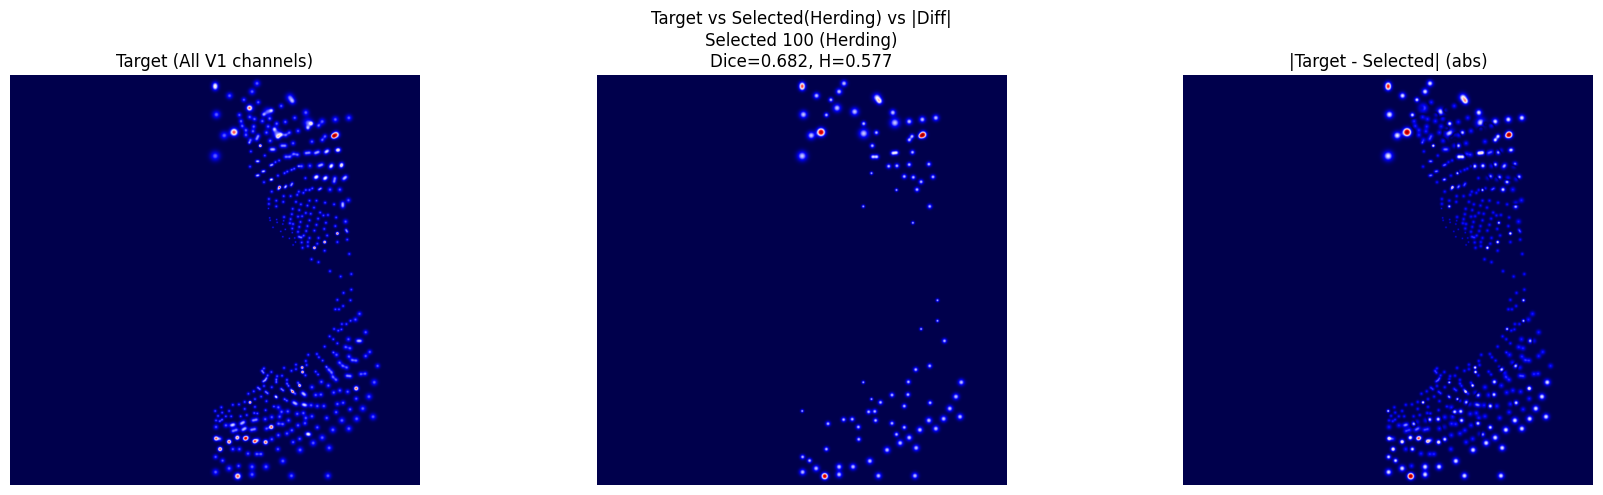

Saved PNG: C:\Users\user\YongtaeC\vimplant0812\data\output\102311\herding_selected_100.png
Saved NPZ: C:\Users\user\YongtaeC\vimplant0812\data\output\102311\herding_selected_100.npz


In [30]:
# -*- coding: utf-8 -*-
# Kernel Herding (MMD minimization) to select 100 channels that best approximate the full-map
# Subject: 102311 RH
# Pickle:  C:\Users\user\YongtaeC\vimplant0812\data\output\102311\102311_RH_V1_n1000_1x10_dice-yield-HD_0.05_targ-full.pkl

import os, pickle
import numpy as np
import matplotlib.pyplot as plt

from electphos import prf_to_phos
from lossfunc import DC, hellinger_distance

# -----------------
# Config
# -----------------
PICKLE_PATH   = r"C:\Users\user\YongtaeC\vimplant0812\data\output\102311\102311_RH_V1_n1000_1x10_dice-yield-HD_0.05_targ-full.pkl"

WINDOWSIZE    = 1000
VIEW_ANGLE    = 90
DC_PERCENTILE = 50

# Downsample for kernels (keeps memory/time sane): 1000 -> 100 (avg pooling)
DOWNSAMPLE    = 10

# Selection
K_SELECT_TGT  = 100

# Kernel (RBF) settings
SIGMA_MODE    = "median"   # "median" | float value
SIGMA_SCALE   = 1.0        # multiply median by this factor

# Van Hoof-like similarity (Yield는 V1 후보 내에서 상수 취급)
A_DICE, B_1mH = 1.0, 1.0

EPS = 1e-12

# -----------------
# Helpers
# -----------------
def normalize_pdf(x, eps=EPS):
    x = np.clip(x, 0, None).astype(np.float32)
    s = float(x.sum())
    return x / (s + eps)

def single_map_raw(phosphenes_block):
    pm = np.zeros((WINDOWSIZE, WINDOWSIZE), dtype=np.float32)
    if phosphenes_block.size == 0:
        return pm
    pm = prf_to_phos(pm, phosphenes_block, view_angle=VIEW_ANGLE, phSizeScale=1)
    return pm  # raw (non-normalized)

def downsample_avg(img, factor=DOWNSAMPLE):
    H, W = img.shape
    assert H % factor == 0 and W % factor == 0, "Image size must be divisible by factor"
    h, w = H // factor, W // factor
    return img.reshape(h, factor, w, factor).mean(axis=(1, 3))

def dice_hellinger_similarity(target_pdf, cand_pdf, bin_thresh):
    dice, _, _ = DC(target_pdf, cand_pdf, bin_thresh)
    H = float(hellinger_distance(cand_pdf.flatten(), target_pdf.flatten()))
    sim = A_DICE * dice + B_1mH * (1.0 - H)
    return dice, H, sim

def build_candidates(phosphenes_V1):
    """
    후보 채널(단일맵 합>0) 선별 + 타깃 raw 맵 생성 + 다운샘플 PDF 행렬 X (n_ch x F_ds)
    """
    M = phosphenes_V1.shape[0]
    cand_idx = []
    X_rows = []  # list of v_i (PDF, shape F_ds)
    target_pm_raw = np.zeros((WINDOWSIZE, WINDOWSIZE), dtype=np.float32)

    for i in range(M):
        pm_raw = single_map_raw(phosphenes_V1[i:i+1, :])
        if pm_raw.sum() <= 0:
            continue
        target_pm_raw += pm_raw
        v_ds = downsample_avg(pm_raw, DOWNSAMPLE).reshape(-1)
        v_pdf = normalize_pdf(v_ds)  # each channel as a PDF "atom"
        X_rows.append(v_pdf)
        cand_idx.append(i)

    if len(cand_idx) == 0:
        raise RuntimeError("유효한 V1 phosphenes 후보가 없습니다.")

    X = np.stack(X_rows, axis=0)  # (n_ch x F_ds) row-wise
    cand_idx = np.asarray(cand_idx, dtype=int)
    return cand_idx, target_pm_raw, X

def rbf_kernel(X, Y=None, sigma=1.0):
    """
    RBF kernel on row-vectors: K_ij = exp(-||x_i - y_j||^2 / (2 sigma^2))
    X: (n x d), Y: (m x d) or None(X)
    """
    if Y is None:
        Y = X
    X = X.astype(np.float64)
    Y = Y.astype(np.float64)
    x2 = np.sum(X*X, axis=1, keepdims=True)        # (n,1)
    y2 = np.sum(Y*Y, axis=1, keepdims=True).T      # (1,m)
    XY = X @ Y.T                                   # (n,m)
    dist2 = x2 + y2 - 2.0 * XY
    K = np.exp(-dist2 / (2.0 * (sigma**2) + EPS))
    return K

def median_heuristic_sigma(X, max_n=400):
    """
    Median of pairwise distances on a subset as bandwidth.
    X: (n x d) row vectors
    """
    n = X.shape[0]
    if n <= 2:
        return 1.0
    rng = np.random.default_rng(0)
    idx = rng.choice(n, size=min(n, max_n), replace=False)
    Z = X[idx]
    # squared distances: ||z_i - z_j||^2
    z2 = np.sum(Z*Z, axis=1, keepdims=True)
    DZ = z2 + z2.T - 2.0 * (Z @ Z.T)
    # take upper triangle without diag
    iu = np.triu_indices_from(DZ, k=1)
    d = np.sqrt(np.clip(DZ[iu], 0.0, None))
    med = np.median(d[d>0]) if np.any(d>0) else 1.0
    return float(med)

# -----------------
# Load pickle
# -----------------
with open(PICKLE_PATH, "rb") as f:
    (res, grid_valid, dice_best, hell_d_best, grid_yield_best,
     contacts_xyz_moved, good_coords, good_coords_V1, good_coords_V2, good_coords_V3,
     phosphenes, phosphenes_V1, phosphenes_V2, phosphenes_V3) = pickle.load(f)

print("Loaded:", os.path.basename(PICKLE_PATH))
print("phosphenes_V1 shape:", phosphenes_V1.shape)

# -----------------
# Build candidates and target
# -----------------
candidate_idx, target_pm_raw, X = build_candidates(phosphenes_V1)  # X: (n_ch x F_ds)
n_ch, F_ds = X.shape
print(f"Valid candidates: {n_ch} | feature dim (downsampled): {F_ds}")

# Target PDF (full-res) & Dice threshold
target_pdf = normalize_pdf(target_pm_raw)
BIN_THRESH = np.percentile(target_pdf, DC_PERCENTILE)

# Target vector in DS space (PDF)
y_ds = normalize_pdf(downsample_avg(target_pm_raw, DOWNSAMPLE).reshape(-1))

# -----------------
# Kernel precompute
# -----------------
if SIGMA_MODE == "median":
    sigma = median_heuristic_sigma(X) * float(SIGMA_SCALE)
else:
    sigma = float(SIGMA_MODE)  # custom numeric

print(f"RBF sigma: {sigma:.4f} (mode={SIGMA_MODE}, scale={SIGMA_SCALE})")

K_xx = rbf_kernel(X, None, sigma=sigma)      # (n_ch x n_ch)
K_xy = rbf_kernel(X, y_ds[None, :], sigma=sigma).reshape(-1)  # (n_ch,)

# -----------------
# Kernel Herding selection (uniform weights)
#   S = argmin MMD^2(P_target, 1/K * sum_{i in S} delta_{x_i})
#   Greedy rule: pick i maximizing m_i - (1/t) * sum_{j in S} K_ij
# -----------------
K_SELECT = min(K_SELECT_TGT, n_ch)
selected_local = []
selected_mask  = np.zeros(n_ch, dtype=bool)
sum_Ki = np.zeros(n_ch, dtype=np.float64)  # ∑_{j∈S} K[:, j]

for t in range(1, K_SELECT + 1):
    # score_i = k(x_i, y) - (1/t)*∑_{j∈S} k(x_i, x_j)
    score = K_xy - (sum_Ki / max(1, t))
    score[selected_mask] = -np.inf
    i_star = int(np.argmax(score))
    selected_local.append(i_star)
    selected_mask[i_star] = True
    sum_Ki += K_xx[:, i_star]

    if t % 10 == 0 or t in (1, K_SELECT):
        print(f"[{t:3d}/{K_SELECT}] chose idx={i_star}  score={score[i_star]:.6f}")

# Map back to original channel ids
selected_channels = candidate_idx[np.array(selected_local, dtype=int)]
print(f"Selected {len(selected_channels)} by kernel herding.")

# -----------------
# Compose selected full-res map & metrics
# -----------------
# Cache raw maps
_raw_cache = {}
def get_raw(ch):
    if ch not in _raw_cache:
        _raw_cache[ch] = single_map_raw(phosphenes_V1[ch:ch+1, :])
    return _raw_cache[ch]

selected_pm_raw = np.zeros_like(target_pm_raw)
for ch in selected_channels:
    selected_pm_raw += get_raw(ch)

selected_pdf = normalize_pdf(selected_pm_raw)

# Van Hoof-style similarity
dice_sel, H_sel, sim_sel = dice_hellinger_similarity(target_pdf, selected_pdf, BIN_THRESH)
print("\nFinal (Kernel Herding / MMD)")
print(f"Dice={dice_sel:.4f}  H={H_sel:.4f}  Sim={sim_sel:.4f}")

# (Optional) Report MMD^2 in RKHS
# MMD^2 = k(y,y) + (1/K^2) 1^T K_SS 1 - (2/K) 1^T m_S
K_SS = K_xx[np.ix_(selected_local, selected_local)]
m_S  = K_xy[selected_local]
k_yy = 1.0  # RBF(y,y)=1
MMD2 = k_yy + (K_SS.sum() / (K_SELECT**2 + EPS)) - (2.0 * m_S.sum() / (K_SELECT + EPS))
print(f"MMD^2 (RBF, DS space) = {MMD2:.6f}")

# -----------------
# Visualization (vimplant-like: 'seismic') + PNG save
# -----------------
diff_pm = np.abs(target_pdf - selected_pdf)

fig, axs = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle("Target vs Selected(Herding) vs |Diff|", fontsize=12)

axs[0].imshow(target_pdf, cmap="seismic")
axs[0].set_title("Target (All V1 channels)")

axs[1].imshow(selected_pdf, cmap="seismic")
axs[1].set_title(f"Selected {len(selected_channels)} (Herding)\nDice={dice_sel:.3f}, H={H_sel:.3f}")

axs[2].imshow(diff_pm, cmap="seismic")
axs[2].set_title("|Target - Selected| (abs)")

for ax in axs: ax.axis("off")
plt.tight_layout(); plt.subplots_adjust(top=0.85)

out_dir = os.path.dirname(PICKLE_PATH)
png_path = os.path.join(out_dir, f"herding_selected_{len(selected_channels)}.png")
plt.savefig(png_path, dpi=200, bbox_inches="tight")
plt.show(); plt.close(fig)

# -----------------
# Save selection & maps
# -----------------
np.savez(os.path.join(out_dir, f"herding_selected_{len(selected_channels)}.npz"),
         selected=selected_channels.astype(int),
         target_pdf=target_pdf.astype(np.float32),
         selected_pdf=selected_pdf.astype(np.float32),
         diff_pm=diff_pm.astype(np.float32),
         ds_factor=np.int32(DOWNSAMPLE),
         sigma=np.float32(sigma),
         candidate_idx=candidate_idx.astype(int))
print("Saved PNG:", png_path)
print("Saved NPZ:", os.path.join(out_dir, f"herding_selected_{len(selected_channels)}.npz"))
